In [1]:
import mmcci

#### Load stLearn data objects

In [2]:
samples = [
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_3.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_4.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_3.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_4.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_stomics_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_stomics_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_stomics_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_stomics_2.pkl')
    ]

In [3]:
# These colours will be used for plotting later

colors = {
    'Ependymal': '#1f77b4',
    'Astrocytes': '#ff7f0e',
    'Vascular': '#2ca02c',
    'Oligos': '#d62728',
    'Neurons': '#9467bd',
    'Microglia': '#8c564b',
    'Immune': '#e377c2',
    'PeripheralGlia': '#7f7f7f'
    }

In [4]:
samples[0]

CCIData object with assays: {'raw': '784 LR pairs'} and metadata: {'n_spots': 2855, 'platform': 'visium', 'age': 'aged'}

#### Normalise each group of samples

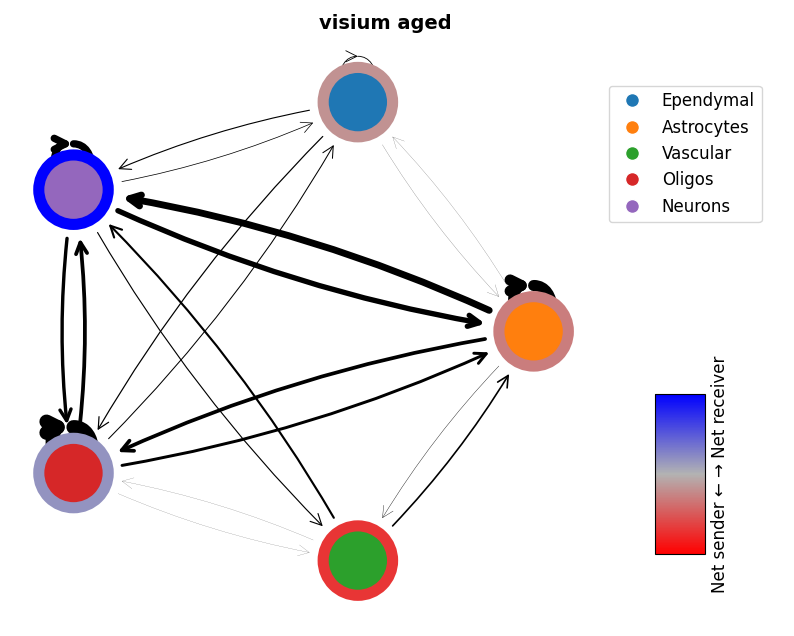

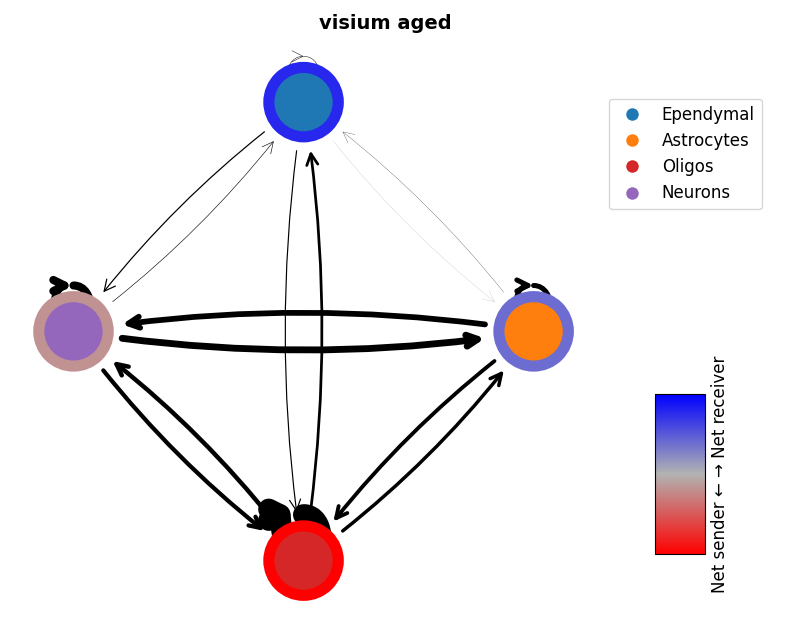

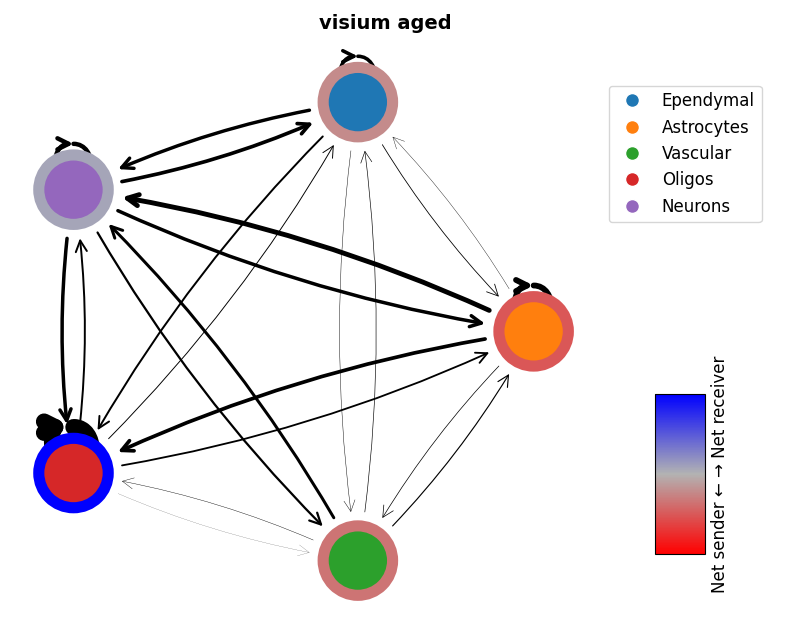

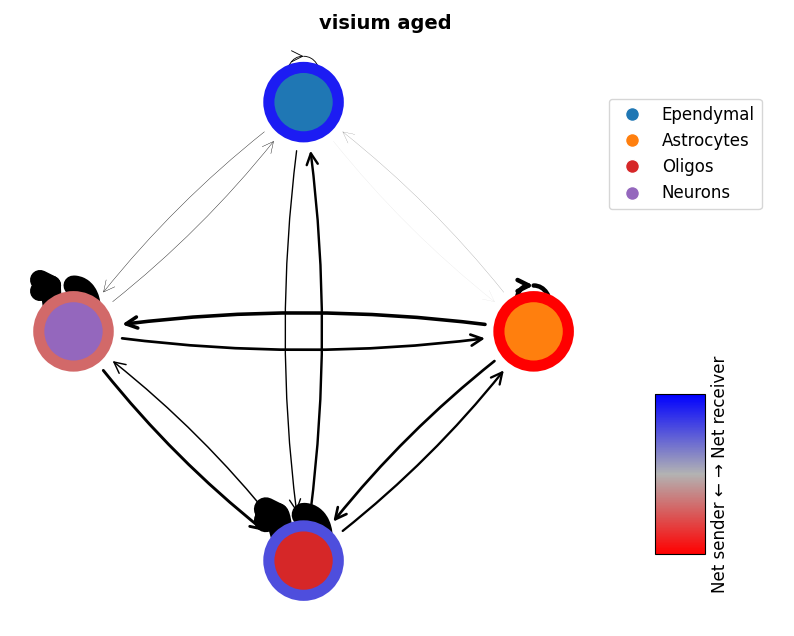

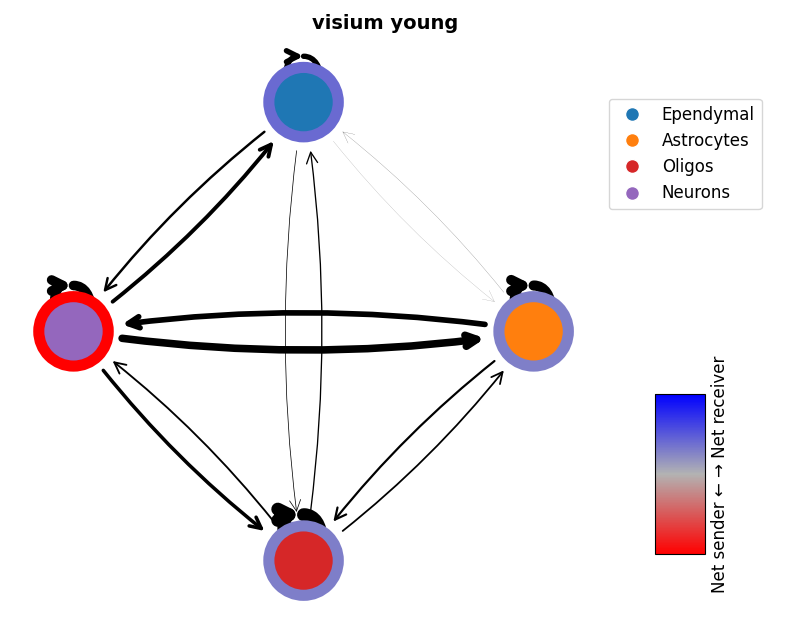

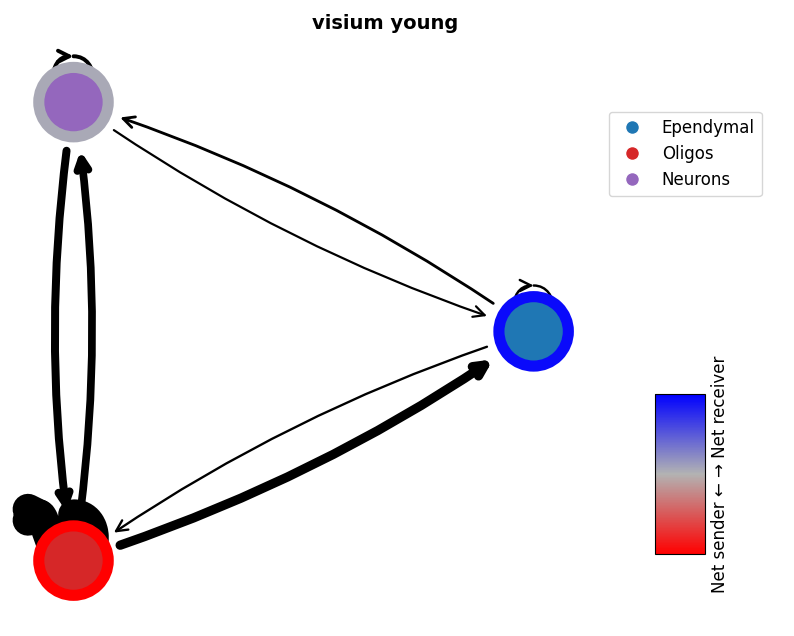

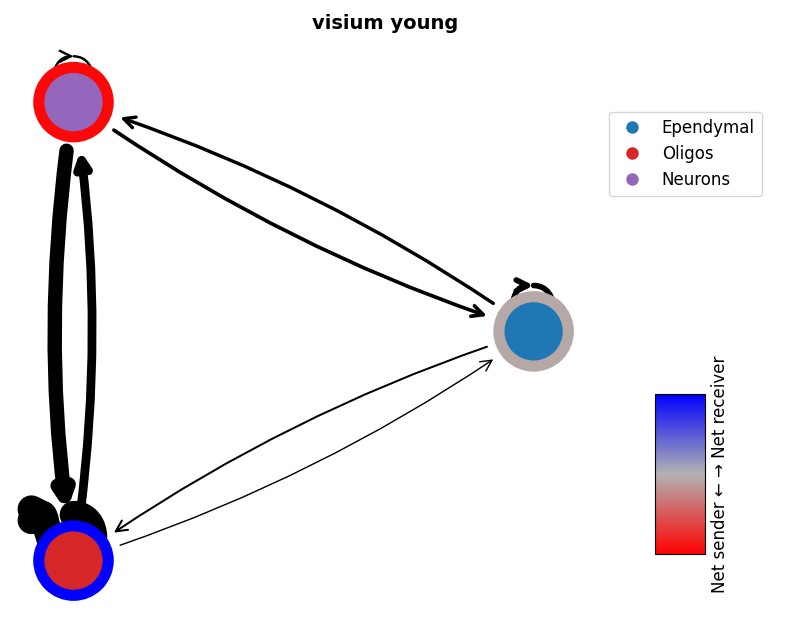

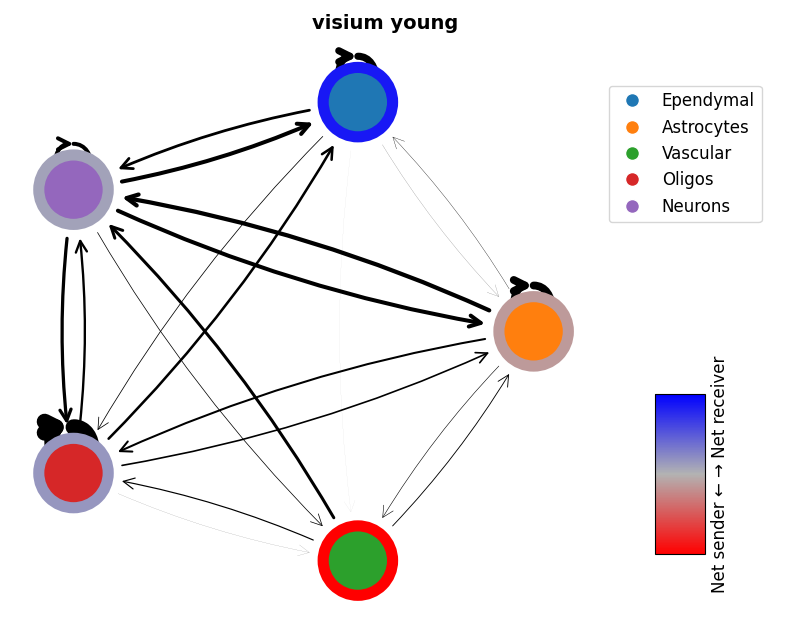

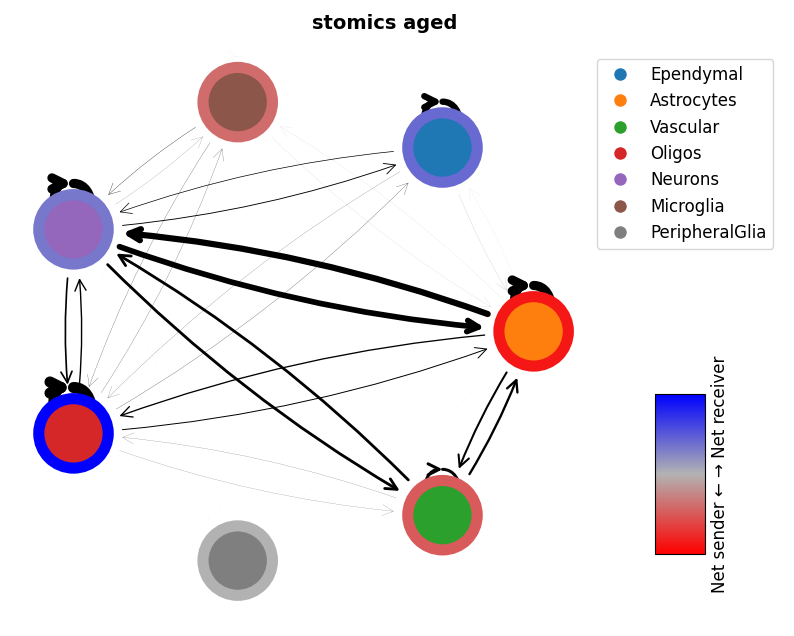

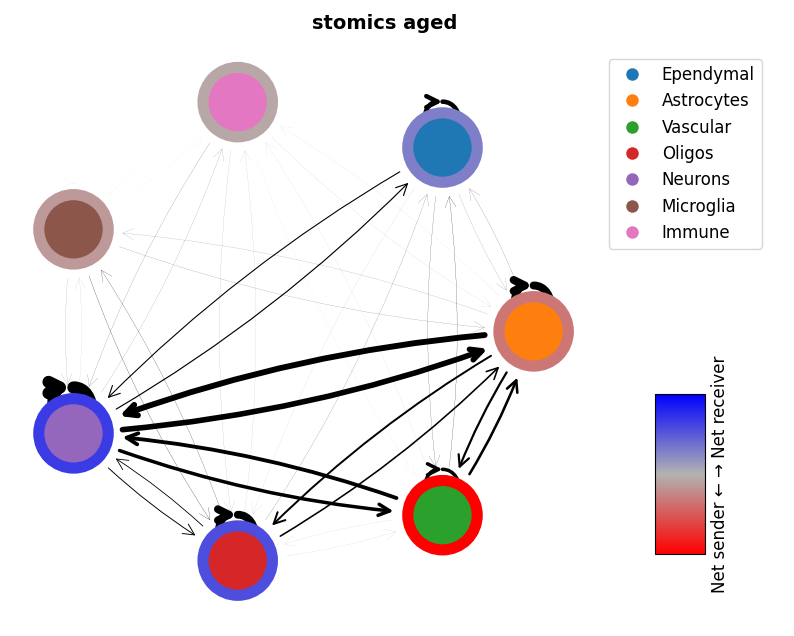

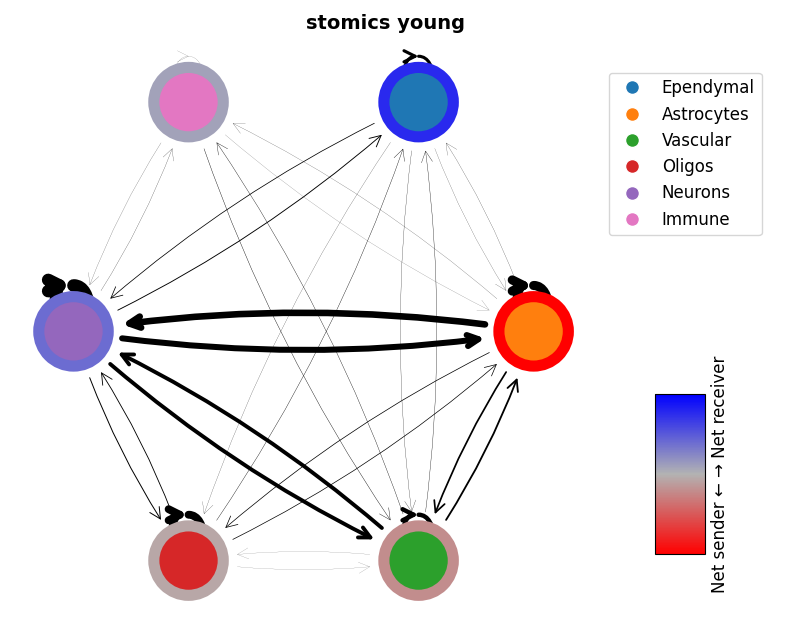

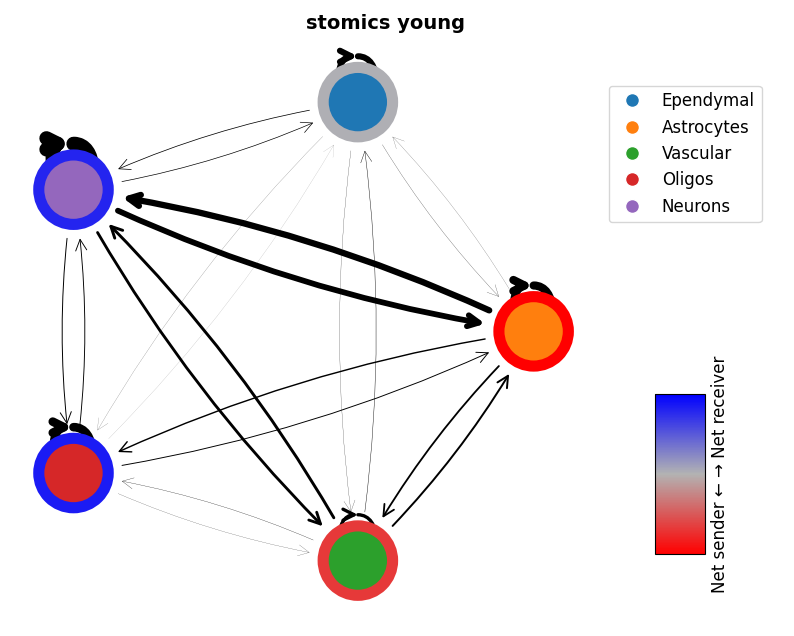

Integrating p values: 100%|██████████| 1253/1253 [00:08<00:00, 155.59it/s]


In [5]:
for i in range(len(samples)):
    
    # Scale by number of Visium/STOmics spots
    # This creates a new assay called 'scaled'
    samples[i] = samples[i].scale_by_nspots()
    
    # Filter out any interactions with a non-significant p-value
    # This creates a new assay called 'filtered'
    samples[i] = samples[i].filter_by_p_vals(assay='scaled')
    
    # Calculate overall interaction scores by summing all LR interactions
    # This creates a new network in the assay called 'overall'
    samples[i] = samples[i].calc_overall(assay='filtered')
    
    mmcci.plt.network_plot(samples[i].assays['filtered']['overall'], node_colors=colors, title=f"{samples[i].metadata['platform']} {samples[i].metadata['age']}")
    
# Perform integration using the 'scaled' assay since the filtering will be done post-integration
# The 'method' parameter specifies the minimum number of samples that must have a specific LR pair to be included in the integrated sample
# The 'strict' parameter specifies whether interactions scores have to be non-zero in the majority of samples to be included in the integrated sample

aged_visium = mmcci.it.lr_integration(samples[0:4], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'visium'})
young_visium = mmcci.it.lr_integration(samples[4:8], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'visium'})
aged_stomics = mmcci.it.lr_integration(samples[8:10], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'stomics'})
young_stomics = mmcci.it.lr_integration(samples[10:12], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'stomics'})

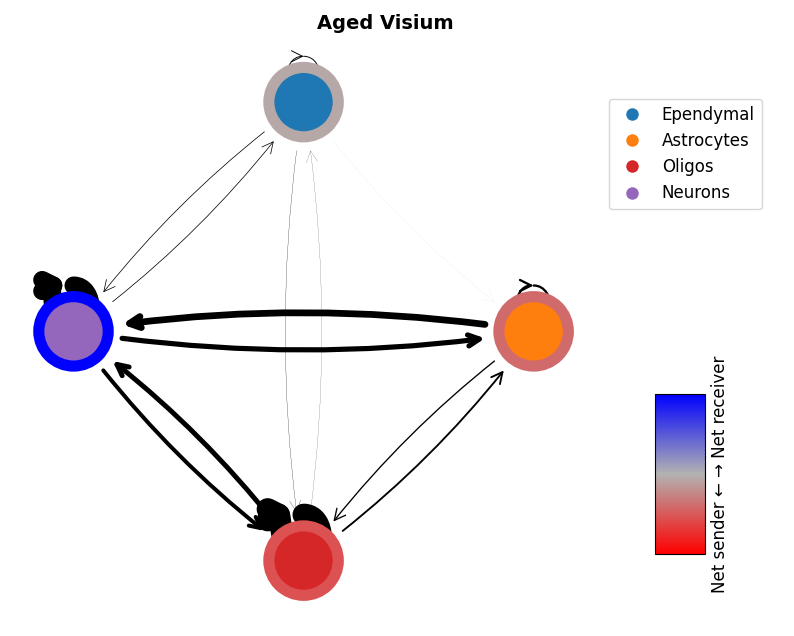

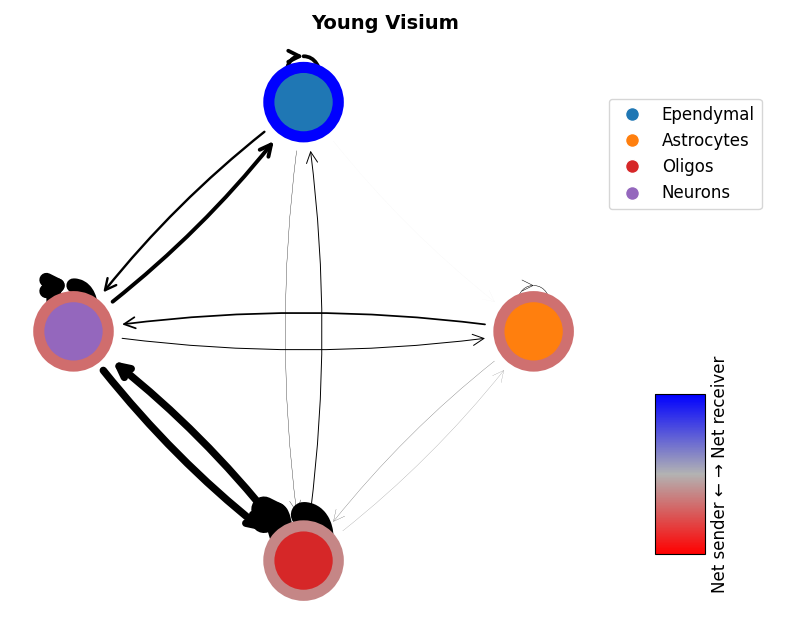

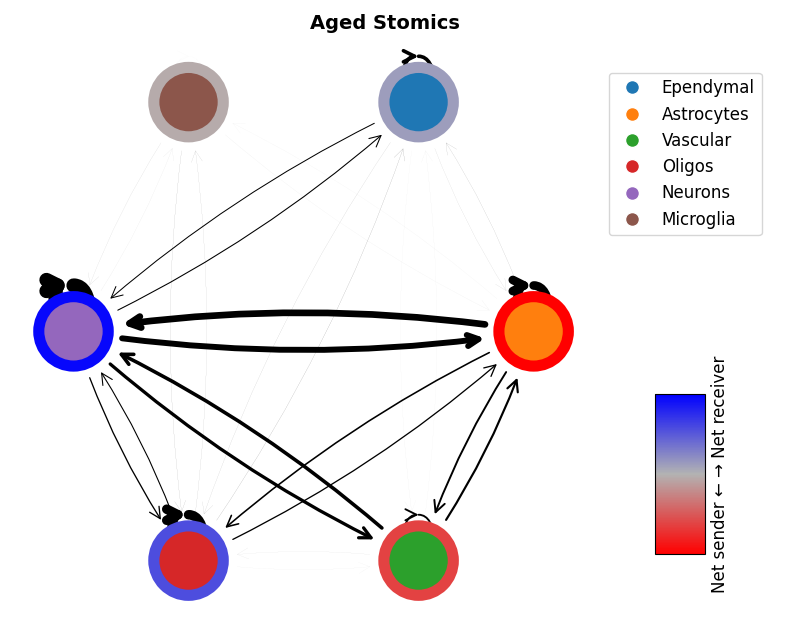

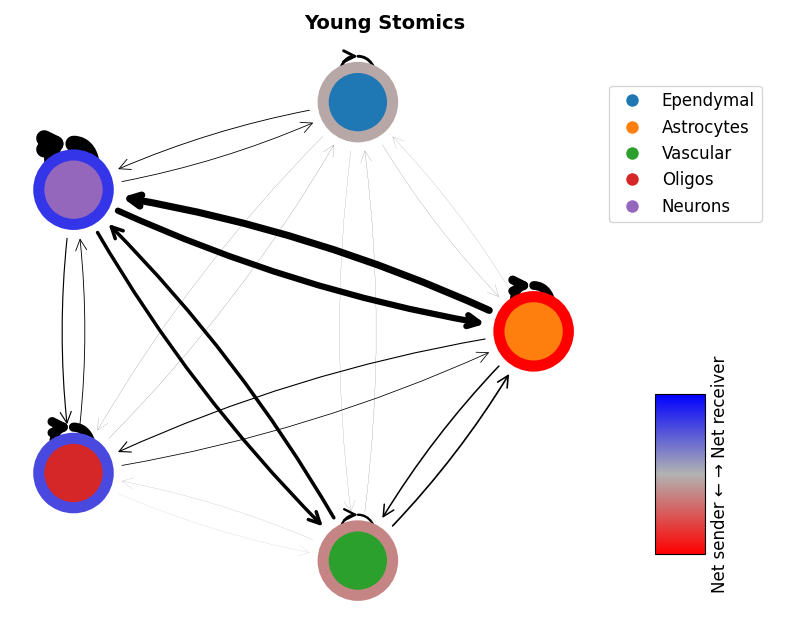

In [6]:
aged_visium = aged_visium.filter_by_p_vals().calc_overall(assay='filtered')
young_visium = young_visium.filter_by_p_vals().calc_overall(assay='filtered')
aged_stomics = aged_stomics.filter_by_p_vals().calc_overall(assay='filtered')
young_stomics = young_stomics.filter_by_p_vals().calc_overall(assay='filtered')

# plot the networks
mmcci.plt.network_plot(aged_visium.assays['filtered']['overall'], node_colors=colors, title='Aged Visium')
mmcci.plt.network_plot(young_visium.assays['filtered']['overall'], node_colors=colors, title='Young Visium')
mmcci.plt.network_plot(aged_stomics.assays['filtered']['overall'], node_colors=colors, title='Aged Stomics')
mmcci.plt.network_plot(young_stomics.assays['filtered']['overall'], node_colors=colors, title='Young Stomics')

Integrating p values: 100%|██████████| 1294/1294 [00:07<00:00, 175.40it/s]


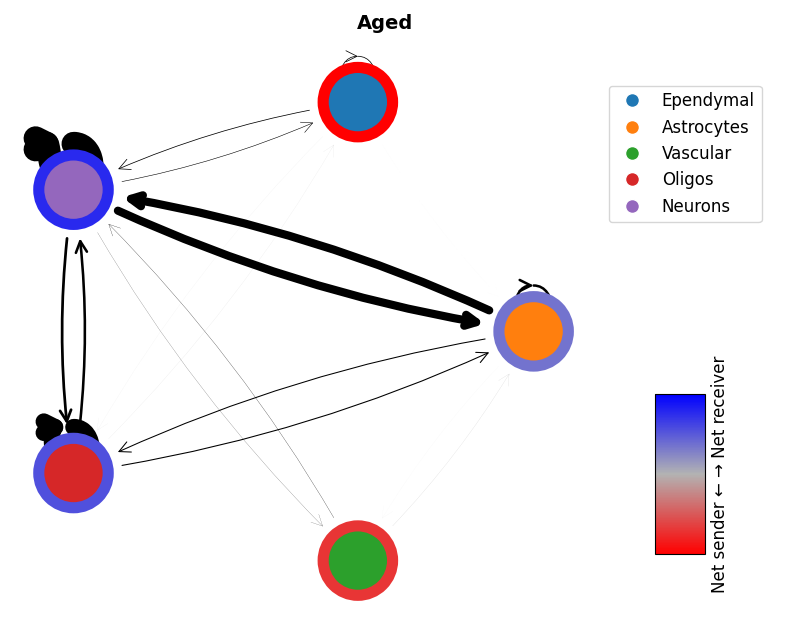

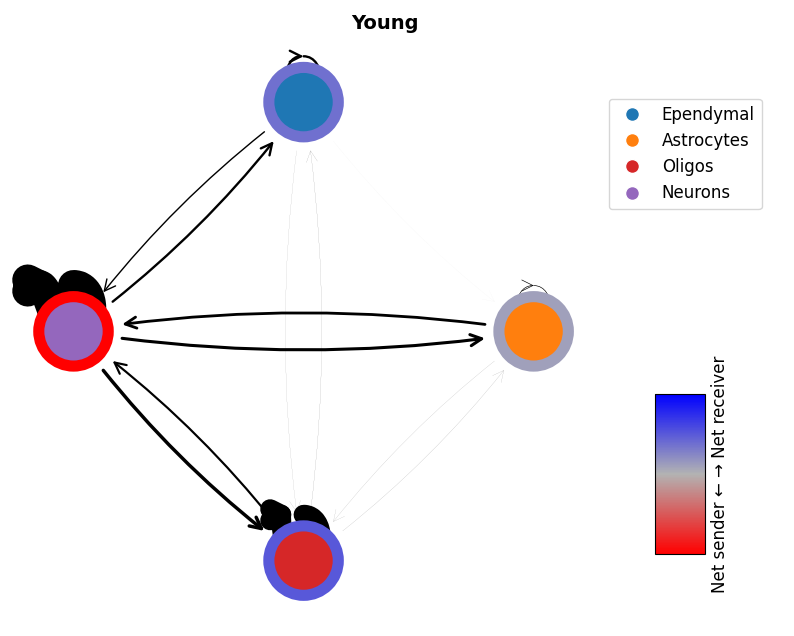

In [7]:
# calculate scale factors between the two platforms
aged_scale_factors = mmcci.it.calc_scale_factors([aged_visium, aged_stomics], assay='raw')
young_scale_factors = mmcci.it.calc_scale_factors([young_visium, young_stomics], assay='raw')

# scale the data using the calculated scale factors
aged_visium = aged_visium.scale(aged_scale_factors['visium'], assay='raw')
young_visium = young_visium.scale(young_scale_factors['visium'], assay='raw')
aged_stomics = aged_stomics.scale(aged_scale_factors['stomics'], assay='raw')
young_stomics = young_stomics.scale(young_scale_factors['stomics'], assay='raw')

# integrate the scaled data
aged = mmcci.it.lr_integration([aged_visium, aged_stomics], method=">50%", strict=True, assay="scaled", metadata={'age': 'aged'})
young = mmcci.it.lr_integration([young_visium, young_stomics], method=">50%", strict=True, assay="scaled", metadata={'age': 'young'})

# filter and calculate overall scores
aged = aged.filter_by_p_vals().calc_overall(assay='filtered')
young = young.filter_by_p_vals().calc_overall(assay='filtered')

# Network plots
mmcci.plt.network_plot(aged.assays['filtered']['overall'], node_colors=colors, title='Aged')
mmcci.plt.network_plot(young.assays['filtered']['overall'], node_colors=colors, title='Young')

#### Rank LR pairs based on dissimilarity between groups

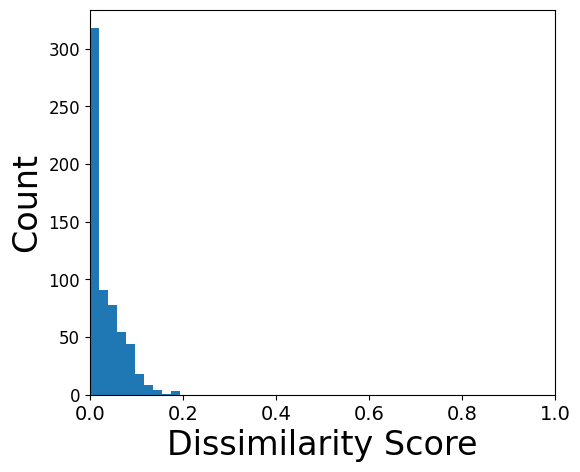

Overall Network Aged vs Young Dissimilarity Score is: 0.23290906762113986


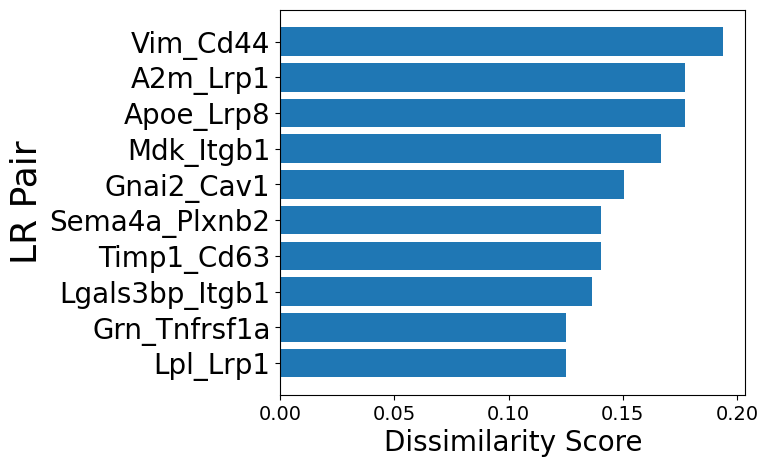

In [8]:
# this calculates a dissimilarity score for each LR pair based on how different their CCI networks are
dissimilarity_scores = mmcci.an.calculate_dissim(aged, young, assay='filtered')
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged.assays['filtered']['overall'], young.assays['filtered']['overall'])))

mmcci.plt.lr_top_dissimilarity(dissimilarity_scores, x_label_size=20, y_label_size=26, y_tick_size=20, figsize=(6,5))

#### Plot highly dissimilar pairs between groups

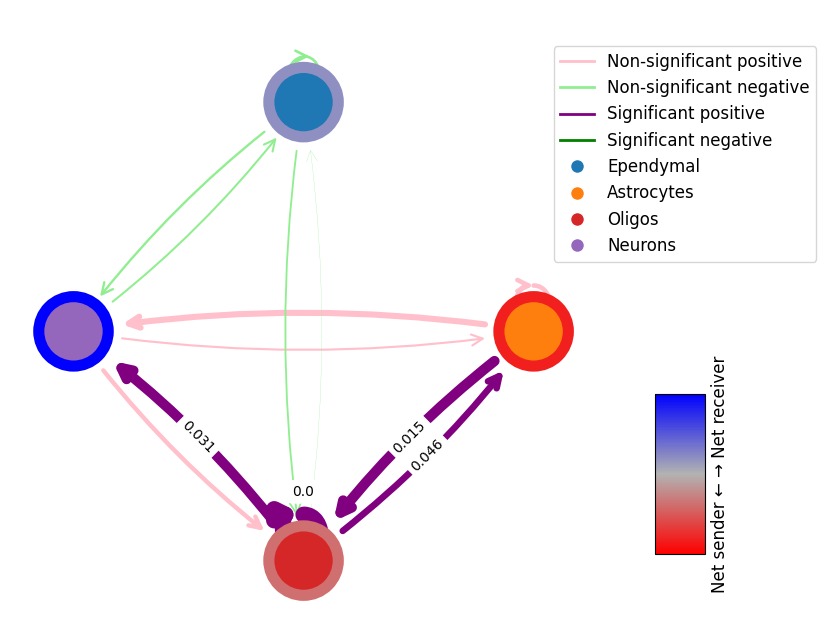

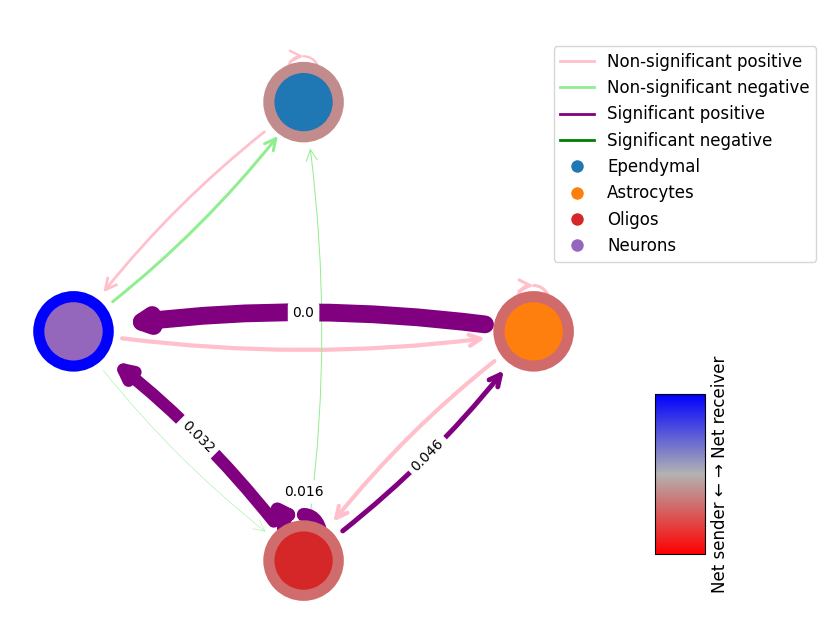

In [9]:
diff = mmcci.an.get_network_diff(aged.assays['filtered']['cci_scores']['Vim_Cd44'], young.assays['filtered']['cci_scores']['Vim_Cd44'])
mmcci.plt.network_plot(diff['diff'], diff['p_vals'], diff_plot=True, node_colors=colors)

diff = mmcci.an.get_network_diff(aged.assays['filtered']['cci_scores']['A2m_Lrp1'], young.assays['filtered']['cci_scores']['A2m_Lrp1'])
mmcci.plt.network_plot(diff['diff'], diff['p_vals'], diff_plot=True, node_colors=colors)

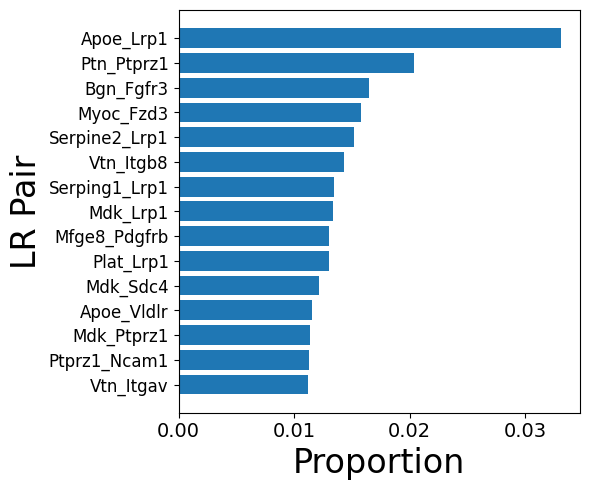

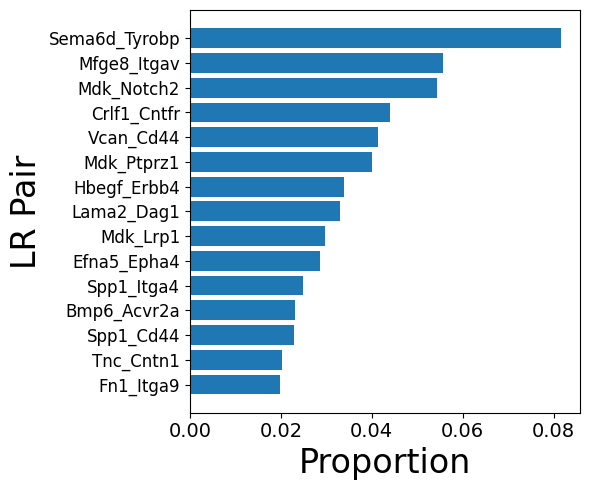

In [10]:
# Aged
mmcci.plt.lrs_per_celltype(aged, sender="Astrocytes", receiver="Neurons")

# Young
mmcci.plt.lrs_per_celltype(young, sender="Astrocytes", receiver="Neurons")

#### Calculate p values for significance changes between groups

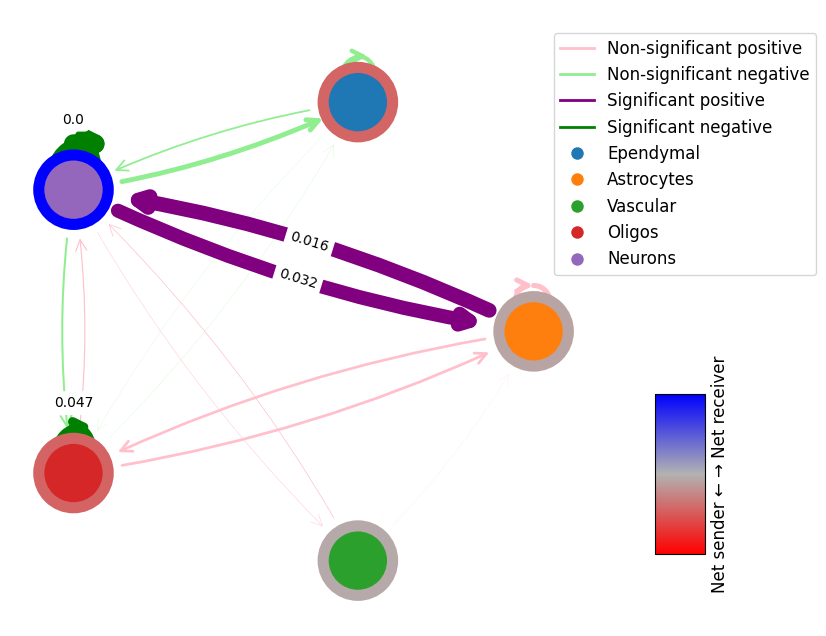

In [11]:
diff = mmcci.an.get_network_diff(aged.assays['filtered']['overall'], young.assays['filtered']['overall'])
mmcci.plt.network_plot(diff['diff'], diff['p_vals'], diff_plot=True, edge_weight=60, node_colors=colors)

#### Cluster Aged and Young LR Pairs

Computing dissimilarity scores for complex interaction networks...


Processing: 100%|██████████| 374/374 [00:37<00:00, 10.09it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 254/254 [00:17<00:00, 14.77it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


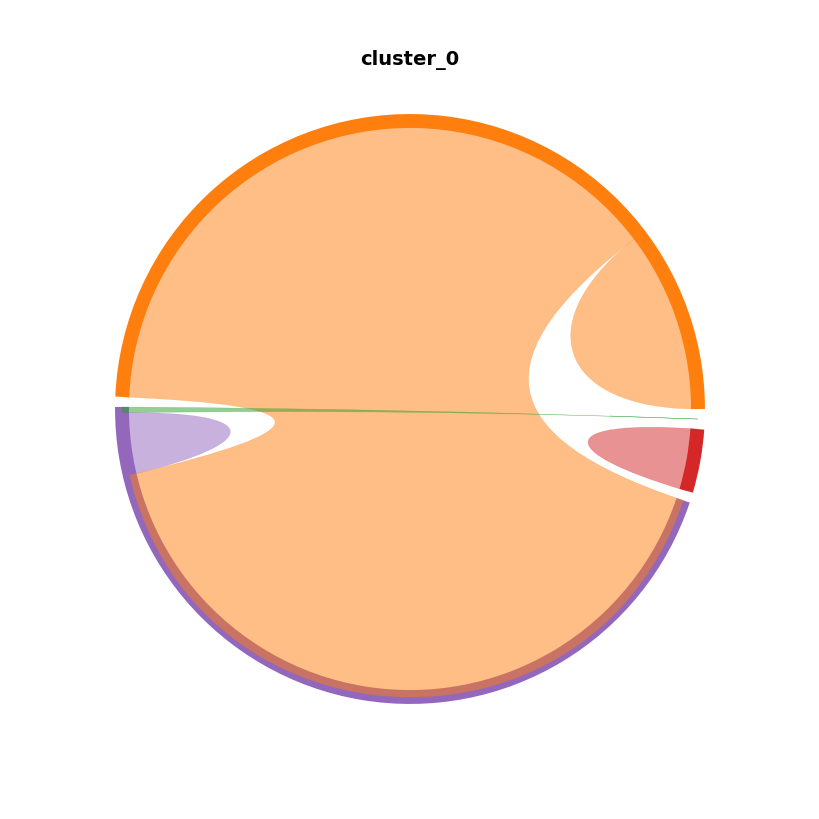

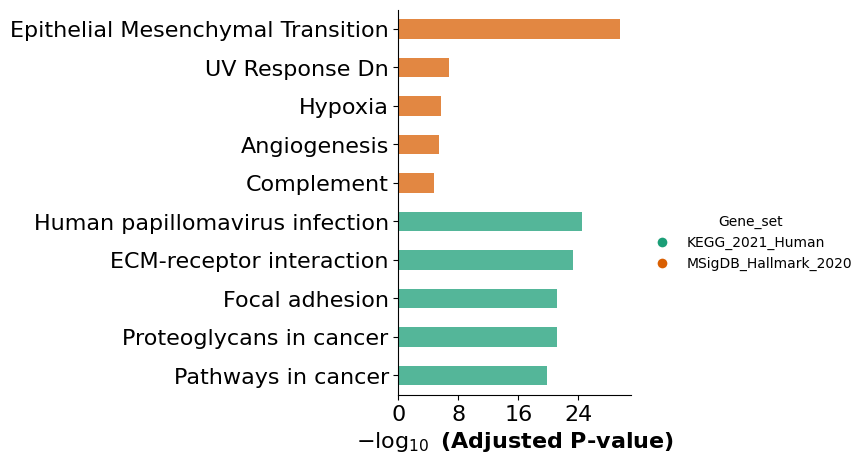

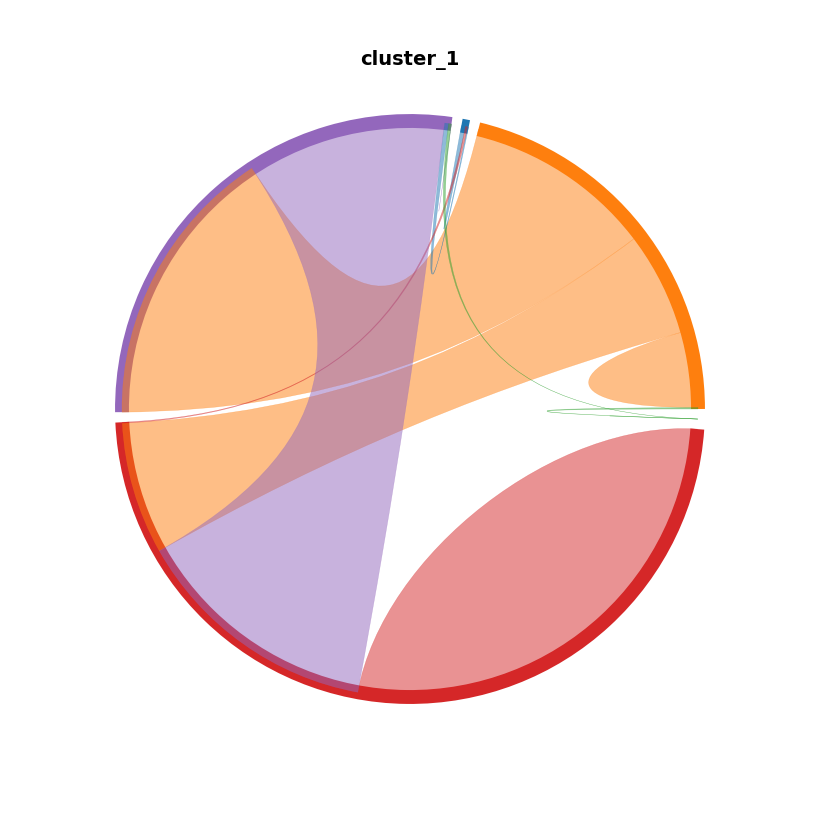

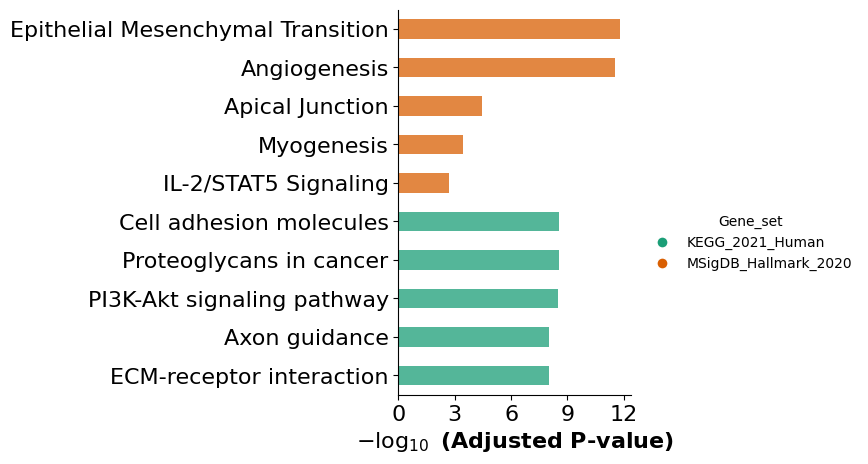

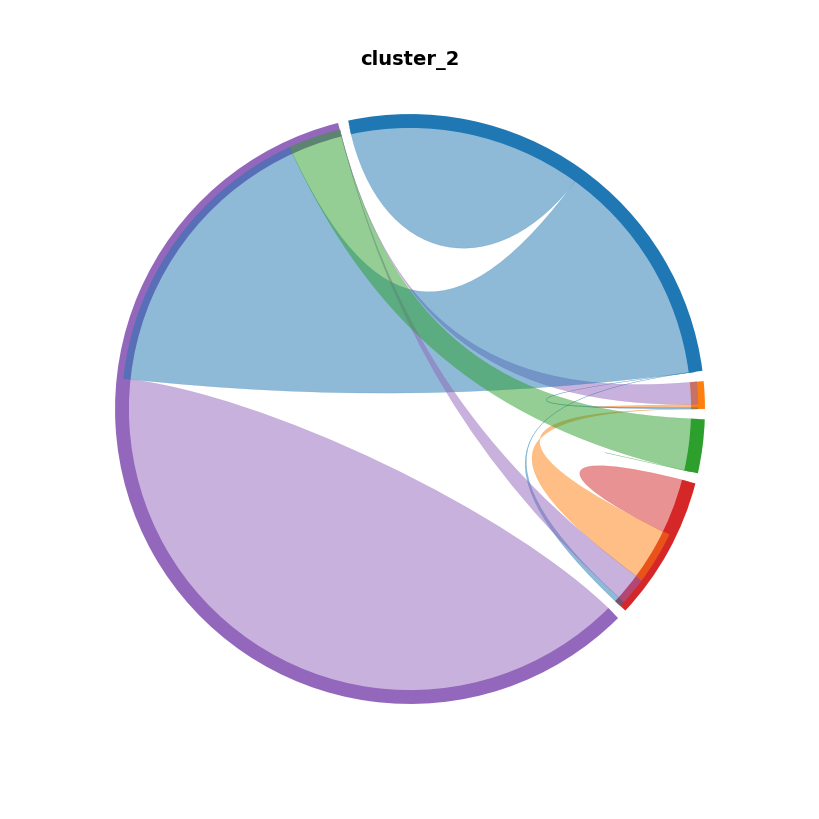

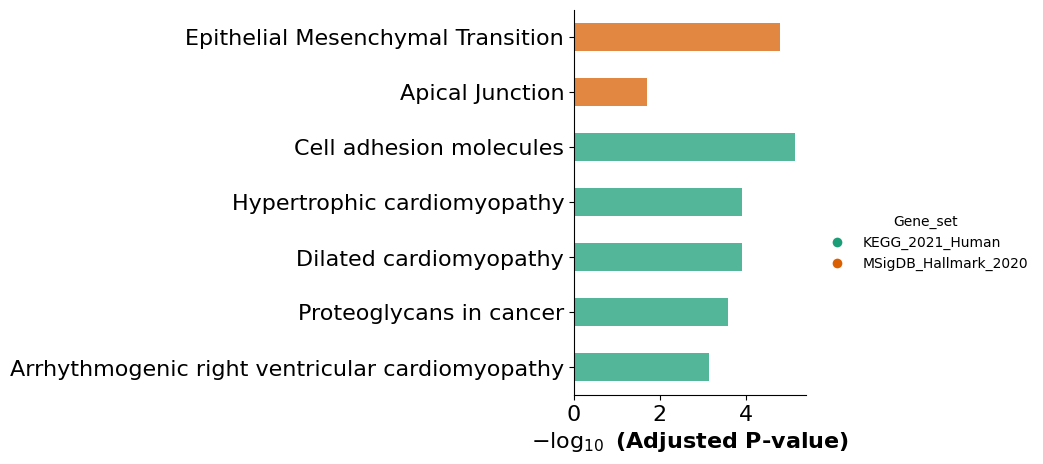

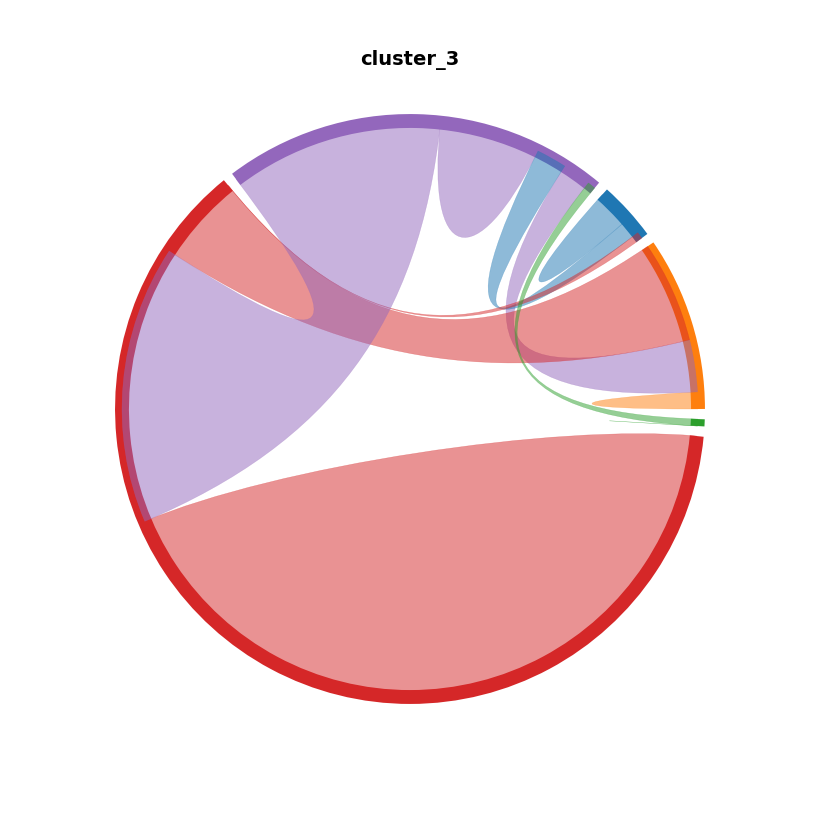

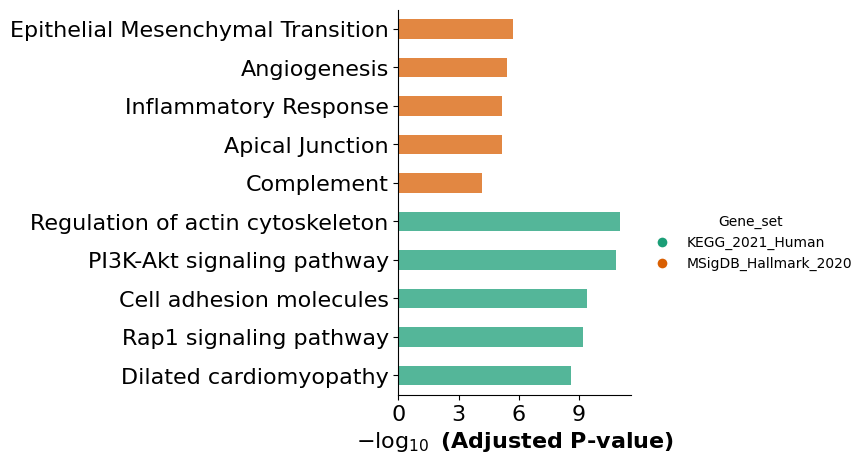

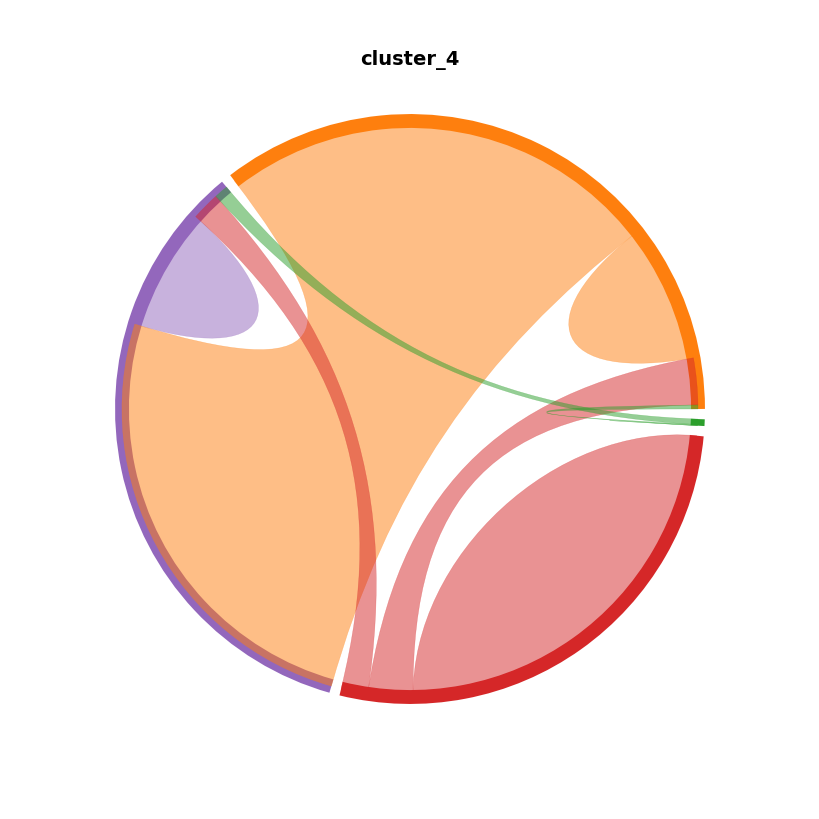

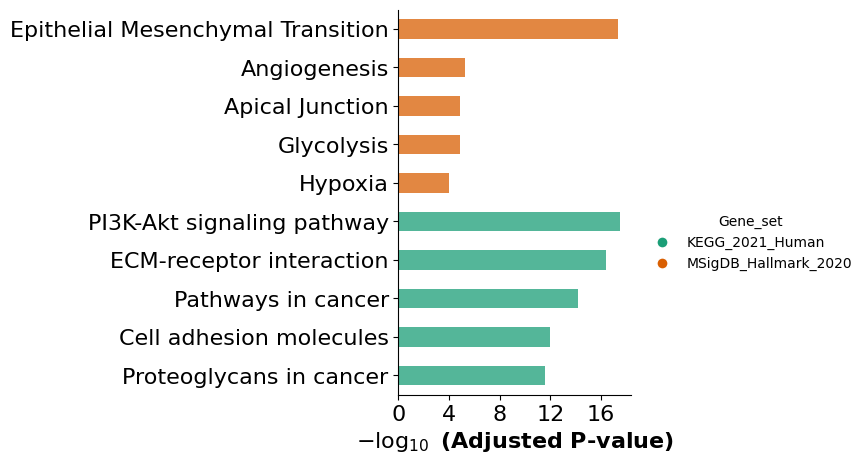

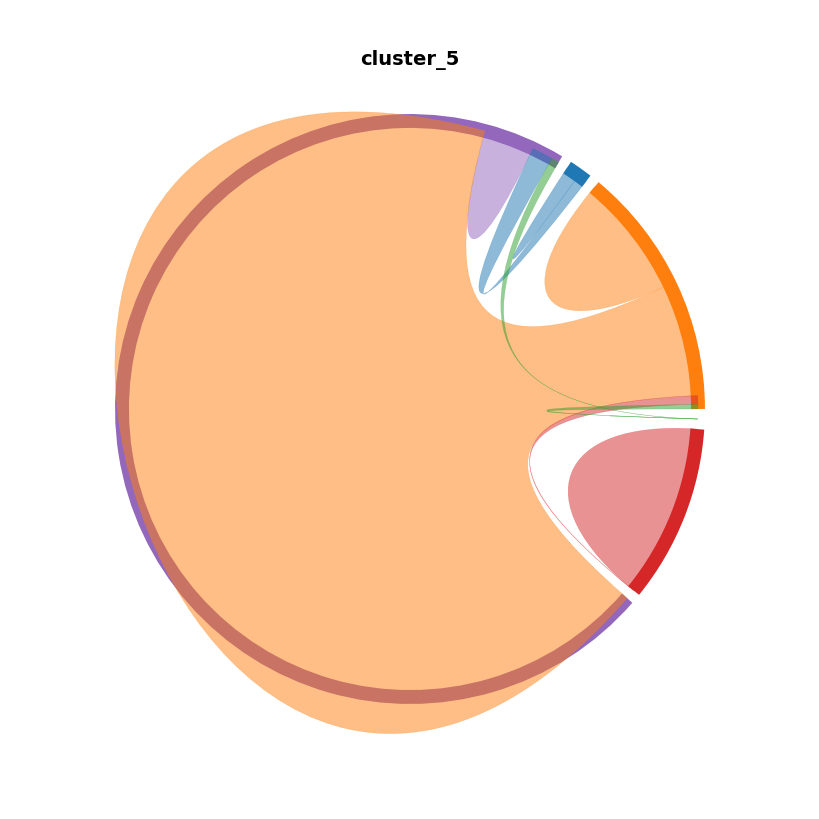

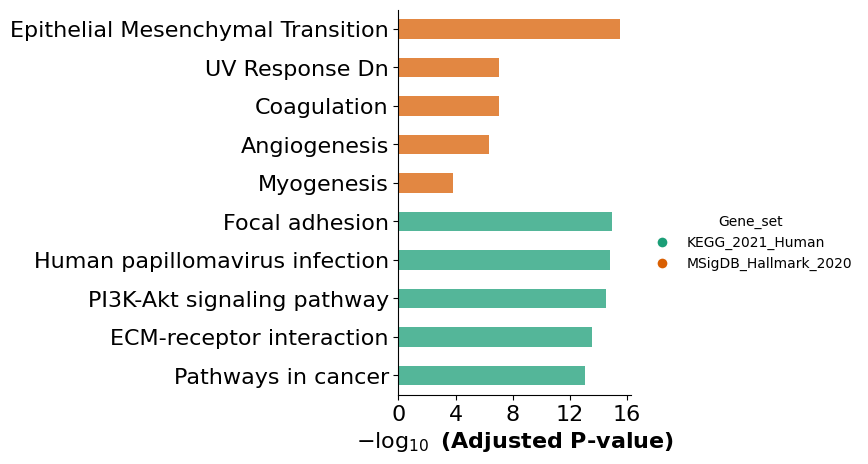

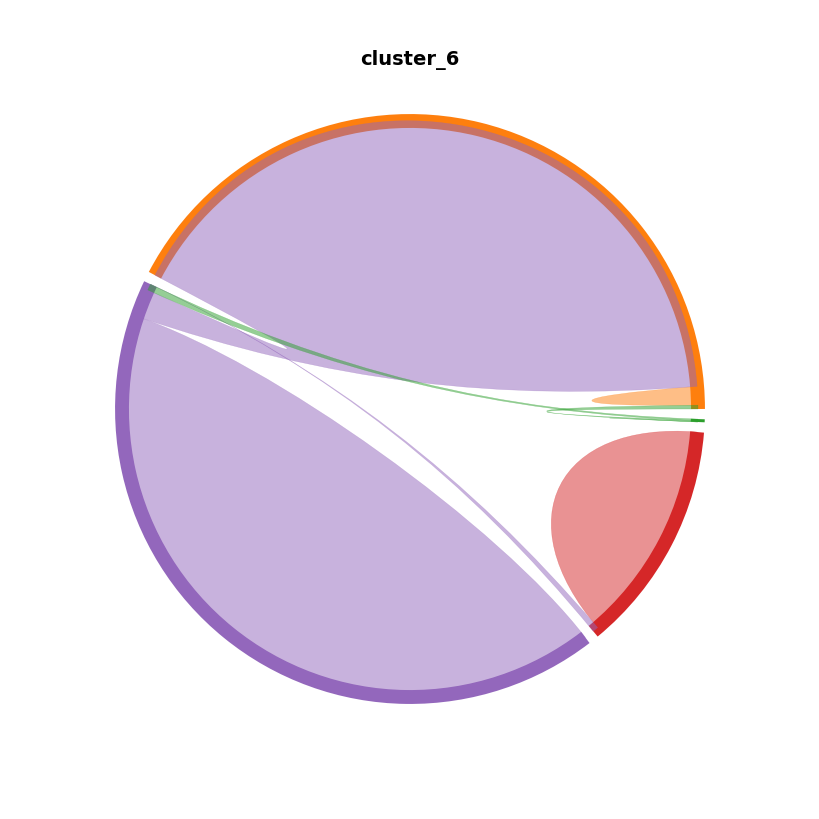

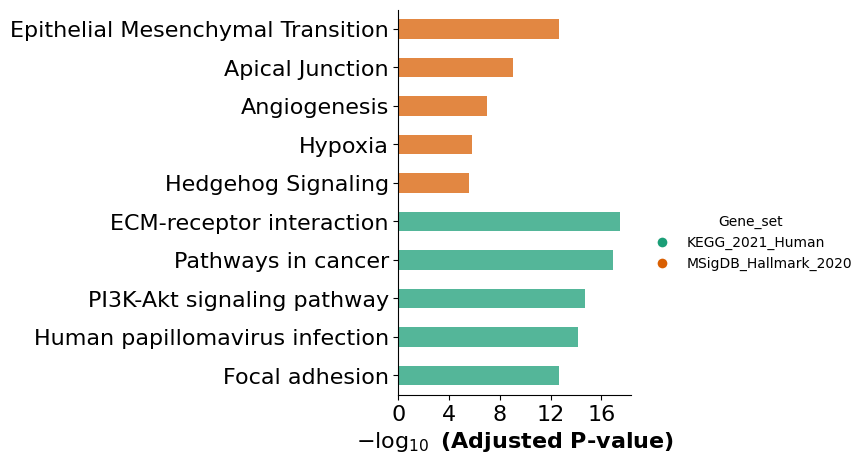

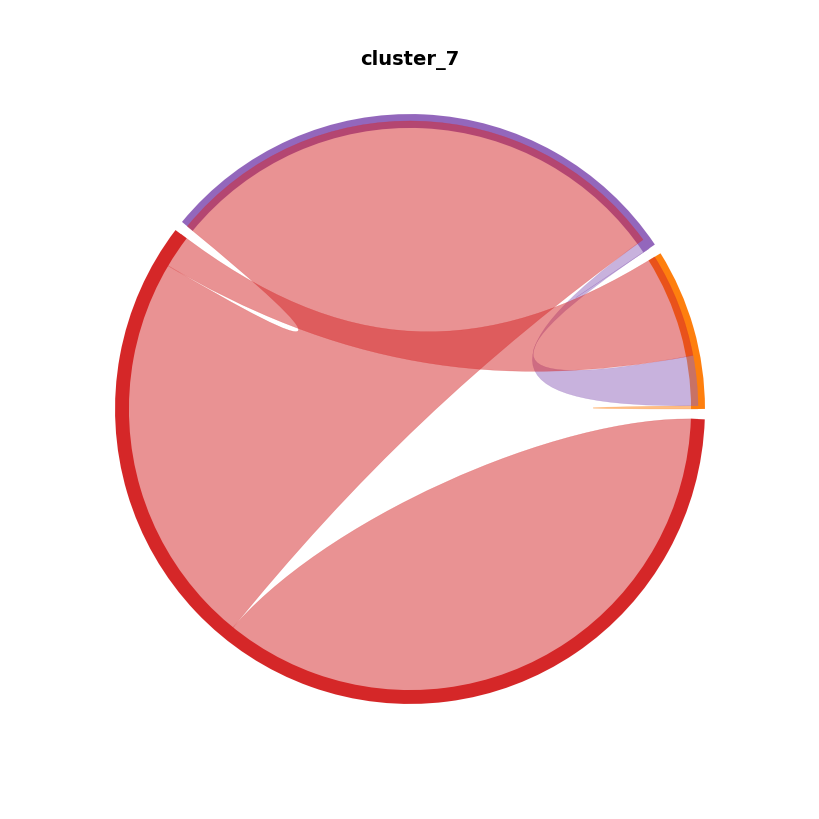

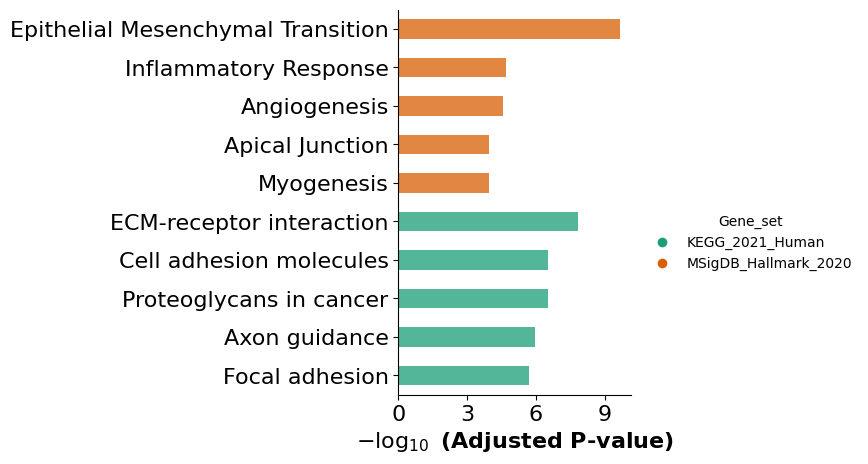

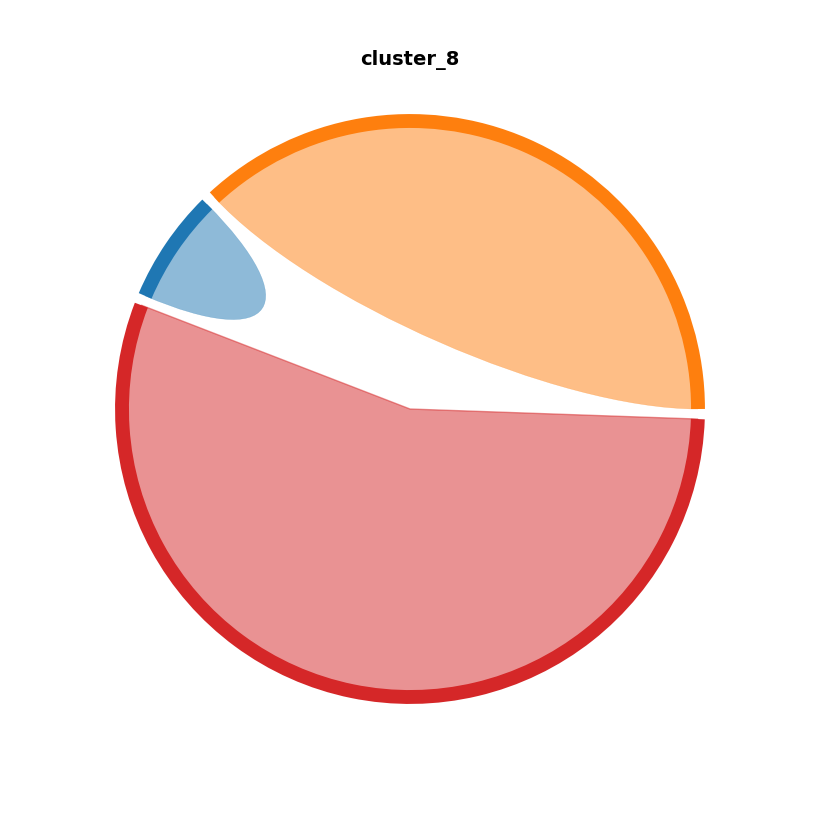

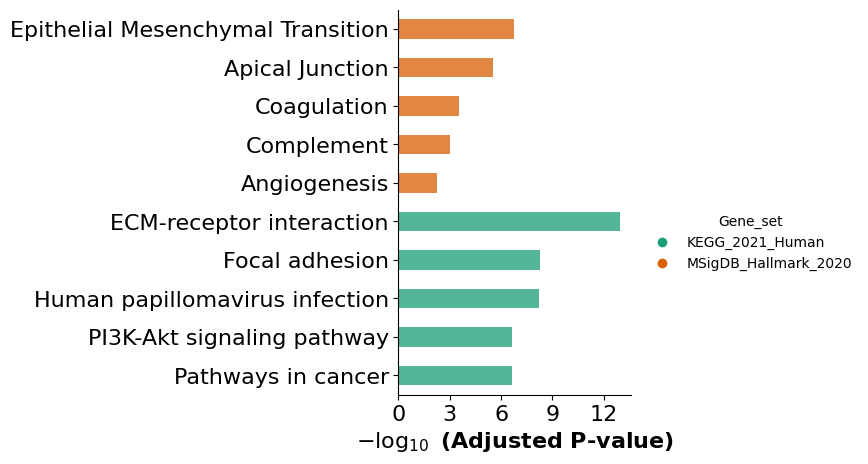

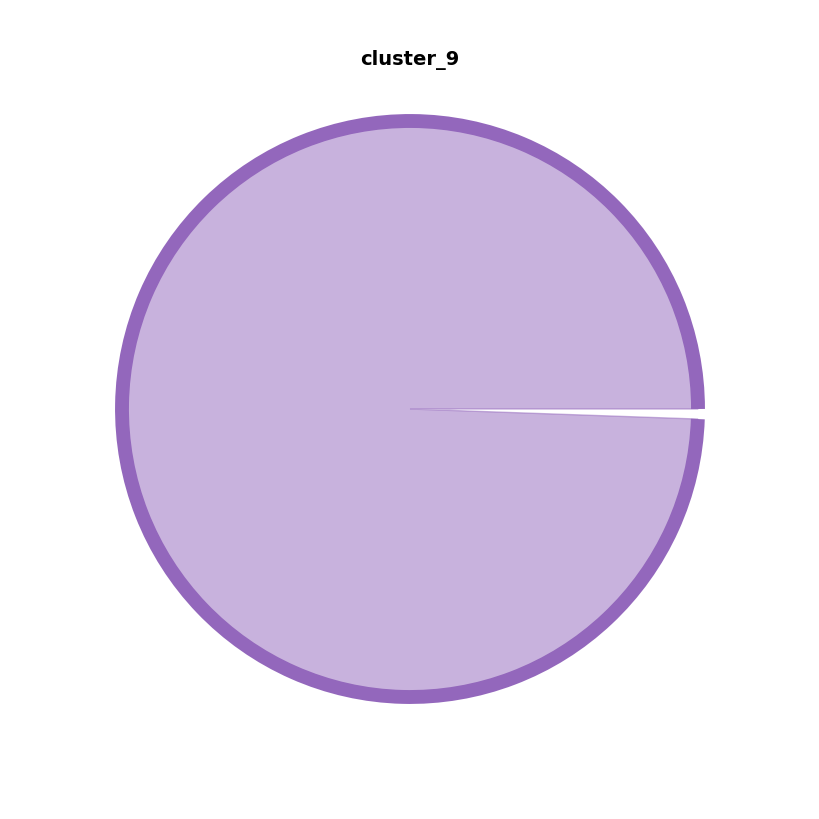

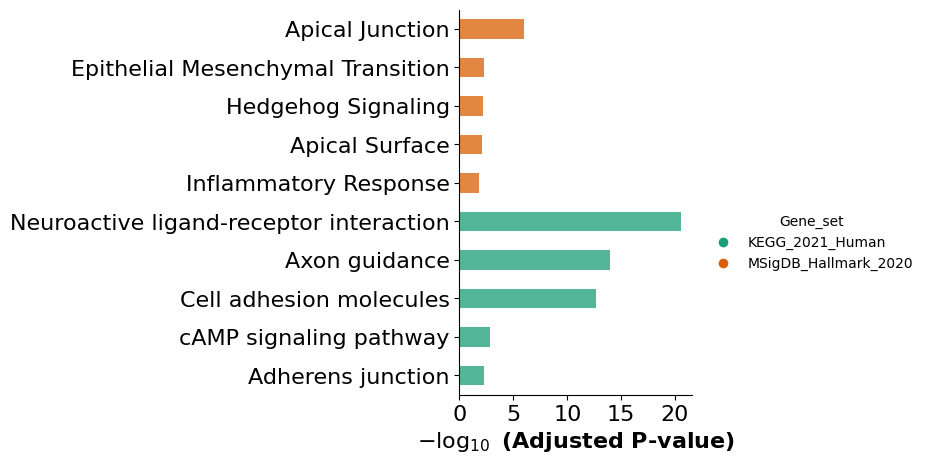

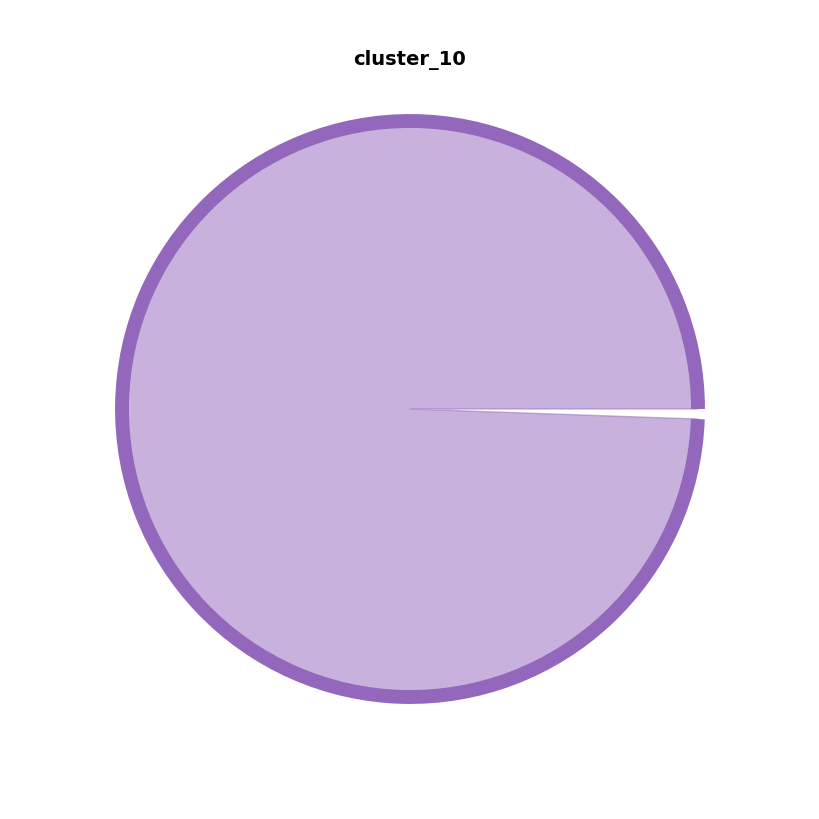

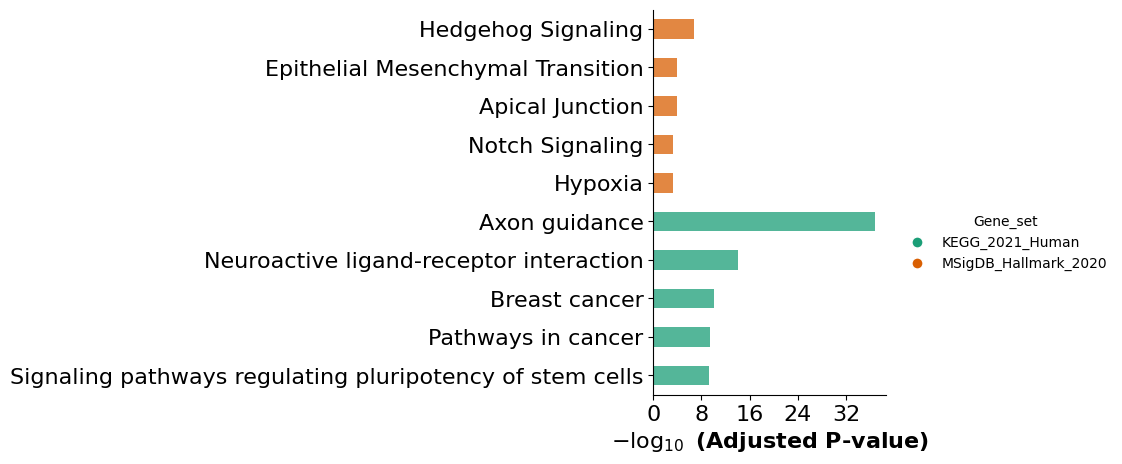

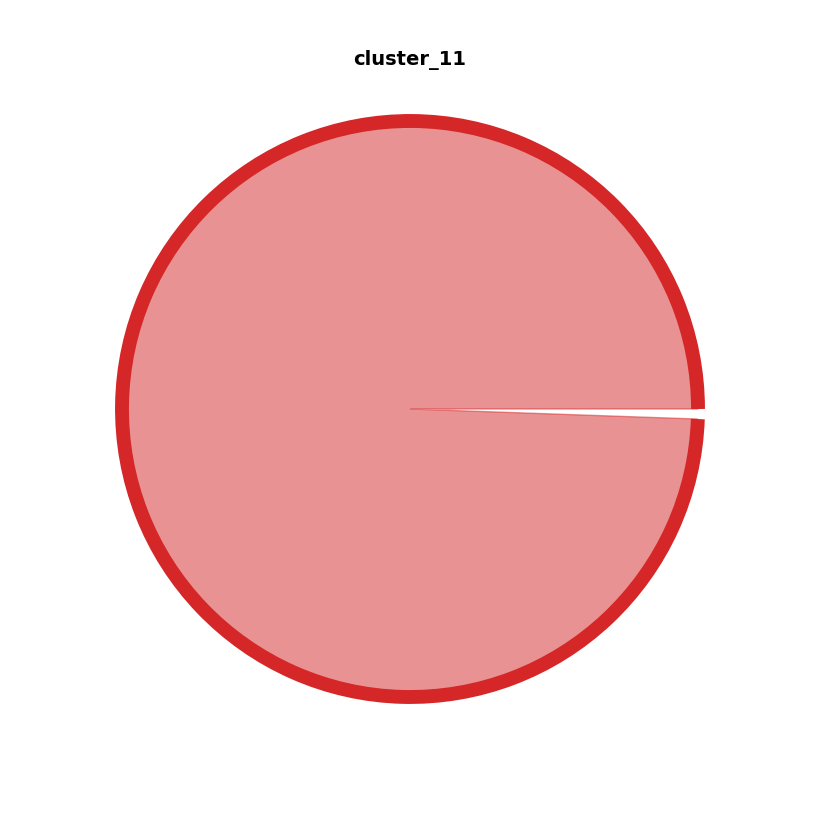

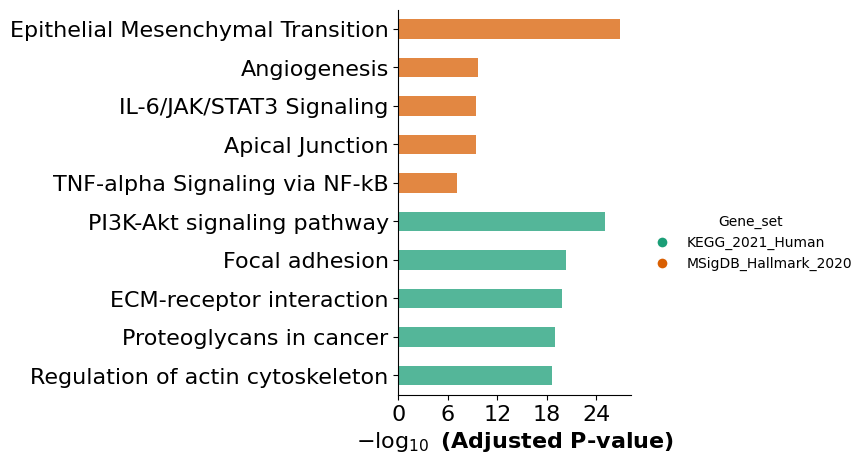

In [12]:
aged = mmcci.an.cell_network_clustering(aged, assay='filtered', n_clusters=0)

for cluster in aged.assays:
    if cluster.startswith('cluster_'):
        mmcci.plt.chord_plot(aged.assays[cluster]['overall'], colors=colors, title=str(cluster), label_size=0)
        mmcci.an.run_gsea(aged, assay=cluster, organism='mouse', return_results=False)

Computing dissimilarity scores for complex interaction networks...


Processing: 100%|██████████| 170/170 [00:08<00:00, 20.71it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 258/258 [00:16<00:00, 15.45it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


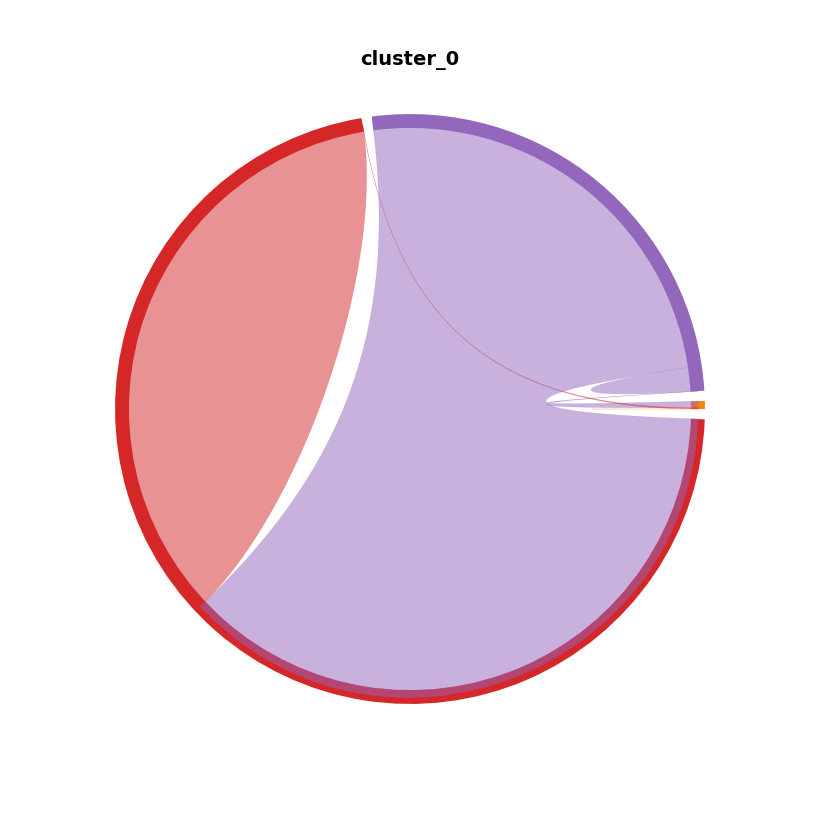

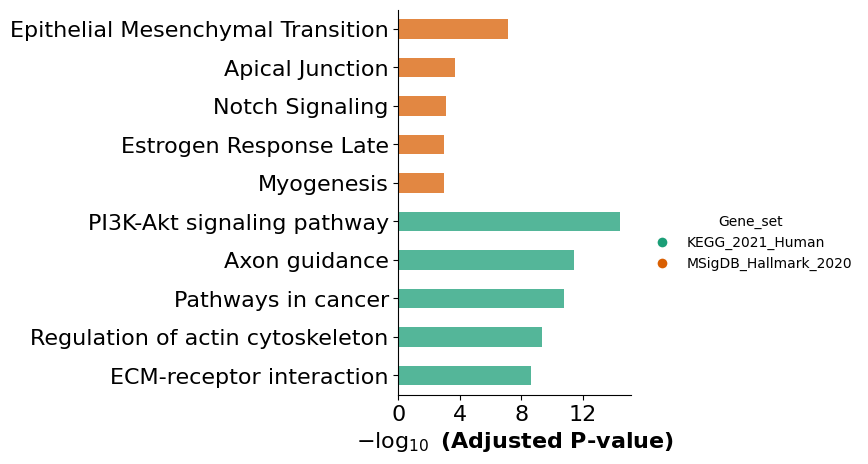

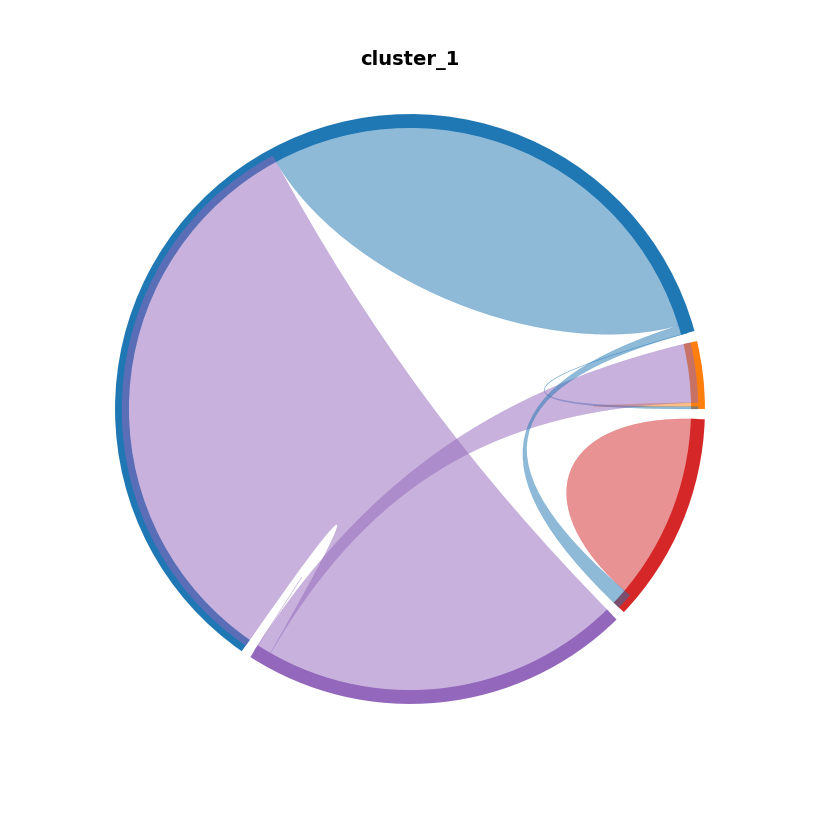

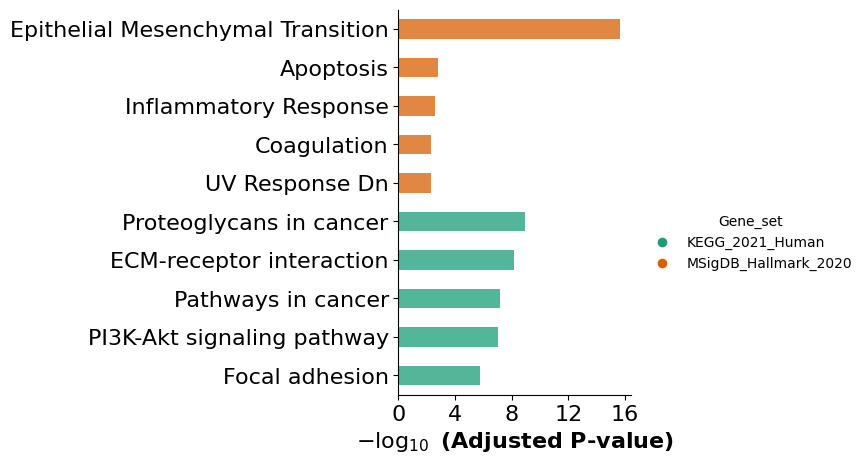

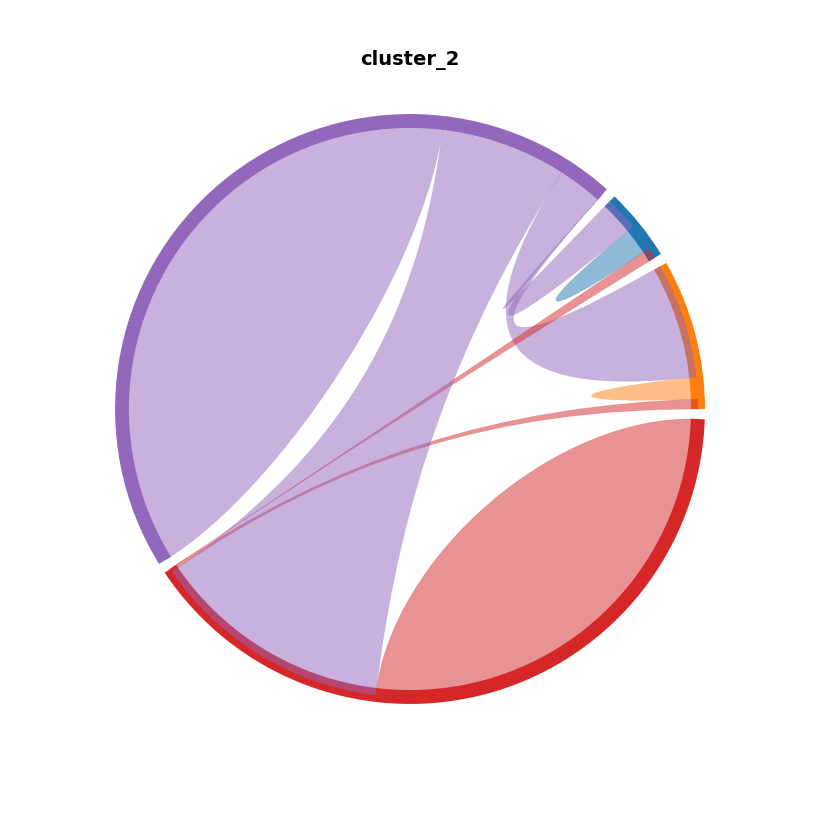

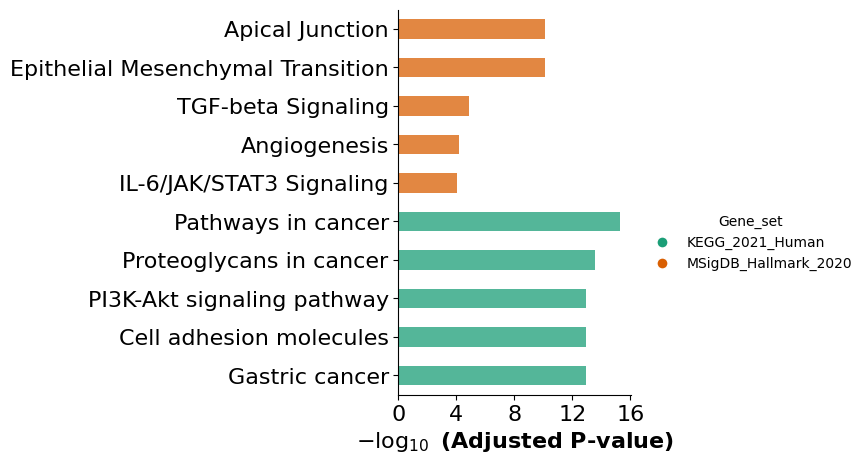

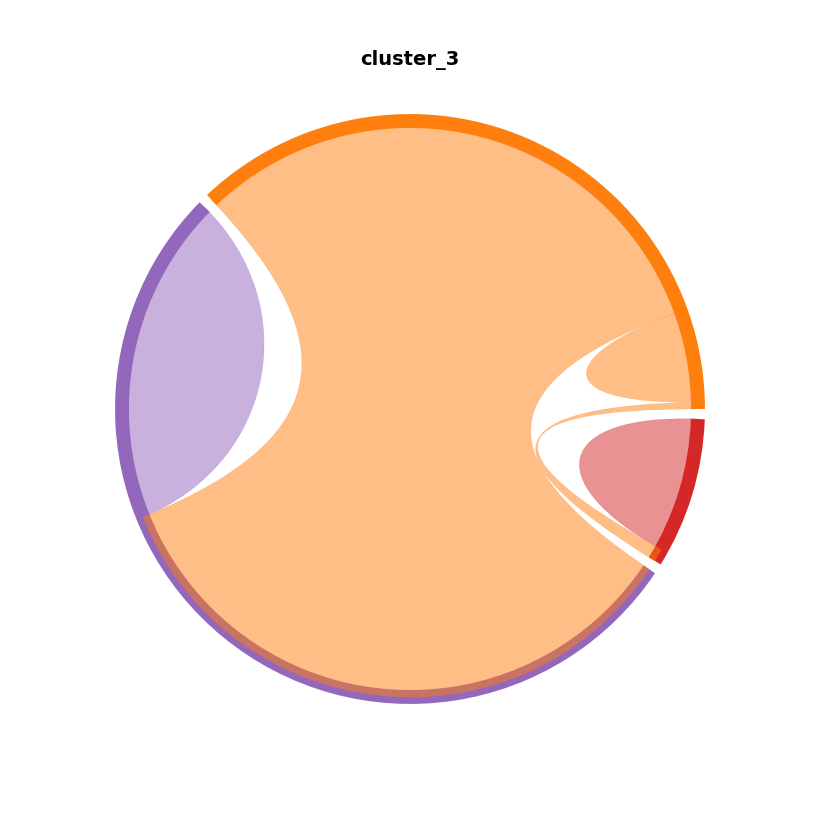

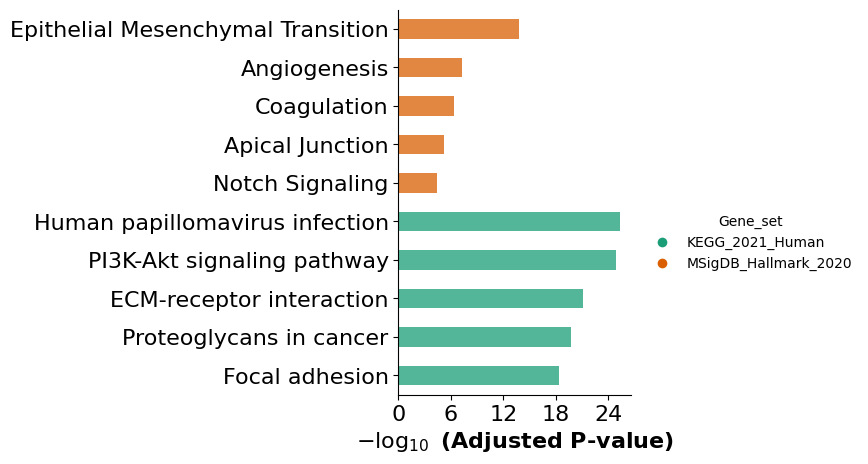

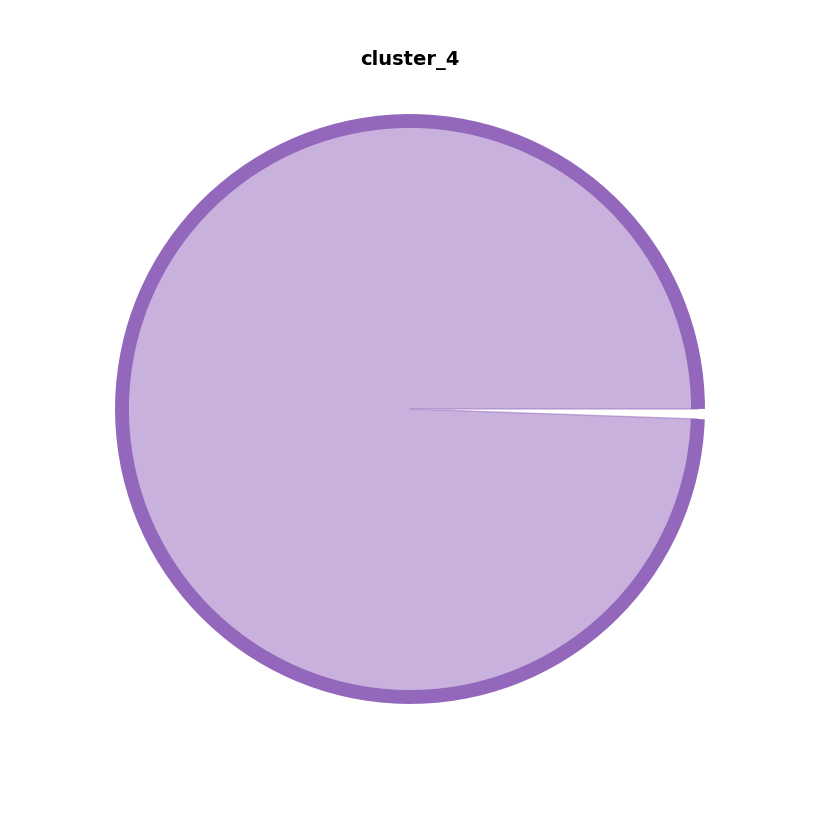

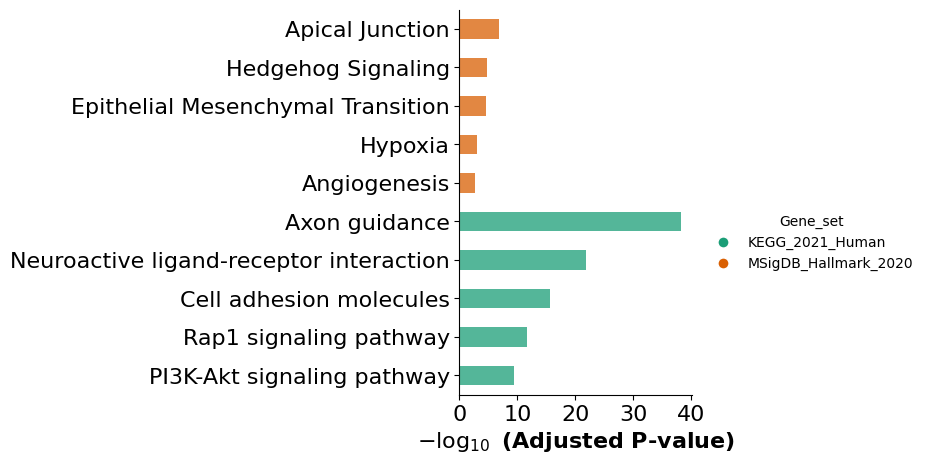

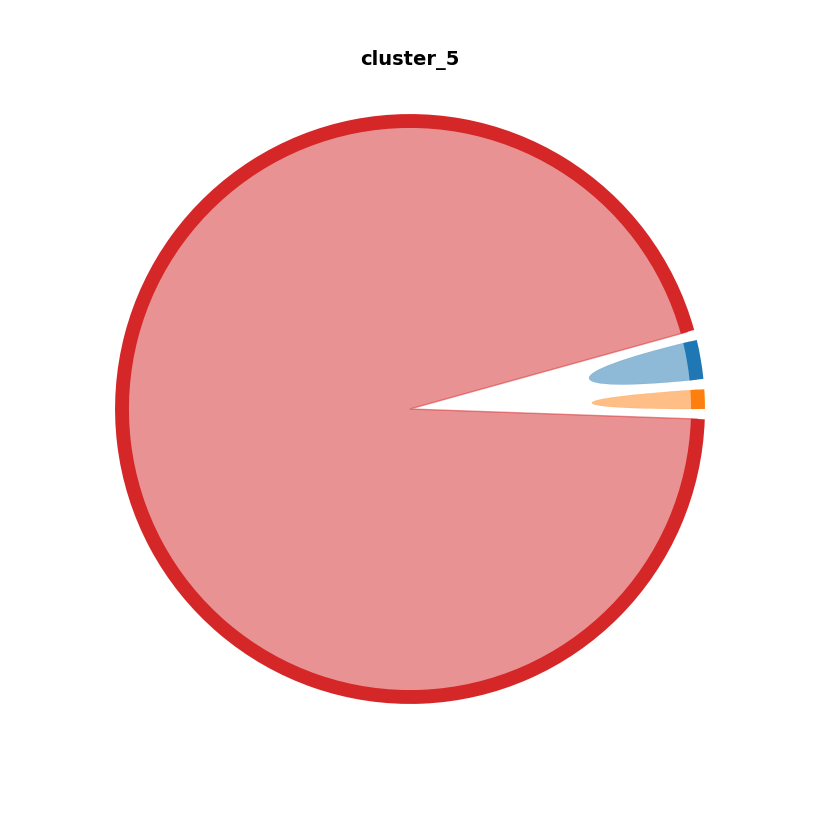

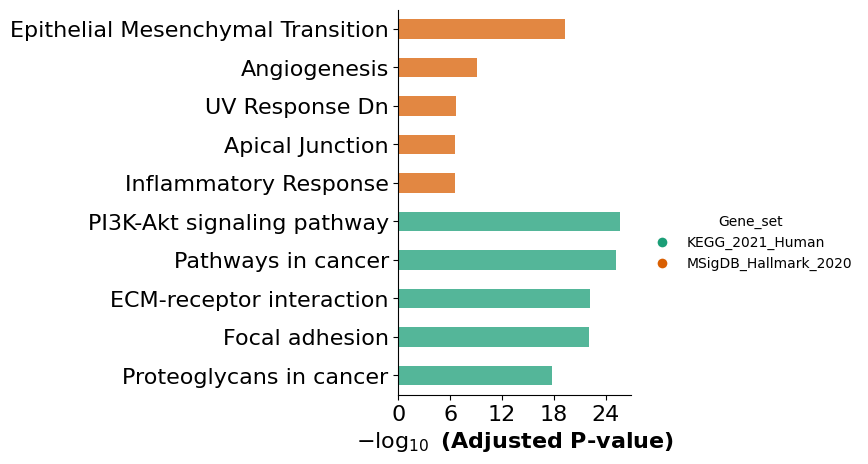

In [13]:
young = mmcci.an.cell_network_clustering(young, assay='filtered', n_clusters=0)

for cluster in young.assays:
    if cluster.startswith('cluster_'):
        mmcci.plt.chord_plot(young.assays[cluster]['overall'], colors=colors, title=str(cluster), label_size=0)
        mmcci.an.run_gsea(young, assay=cluster, organism='mouse', return_results=False)

Number of interactions in complement: 50


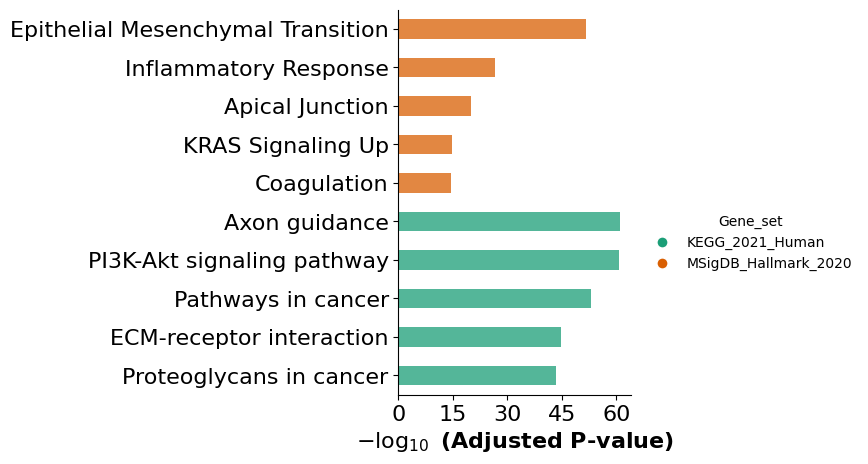

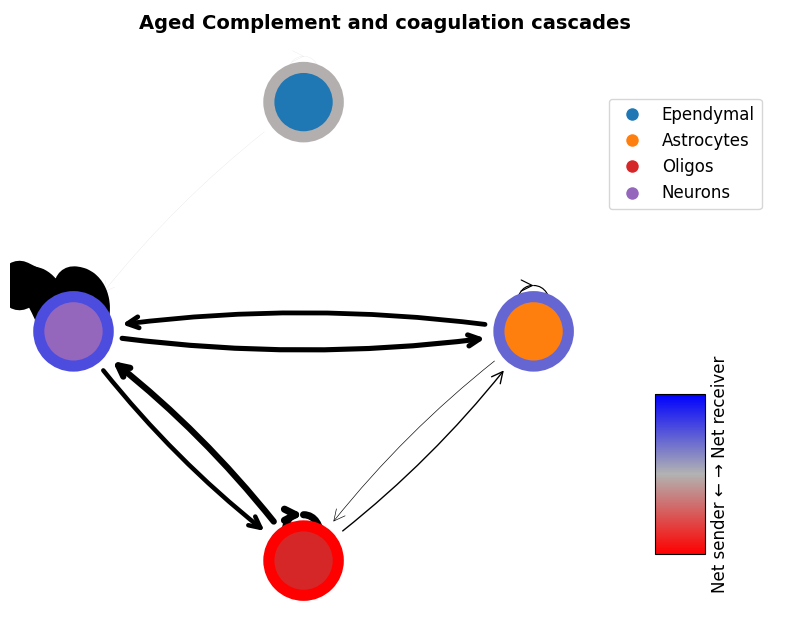

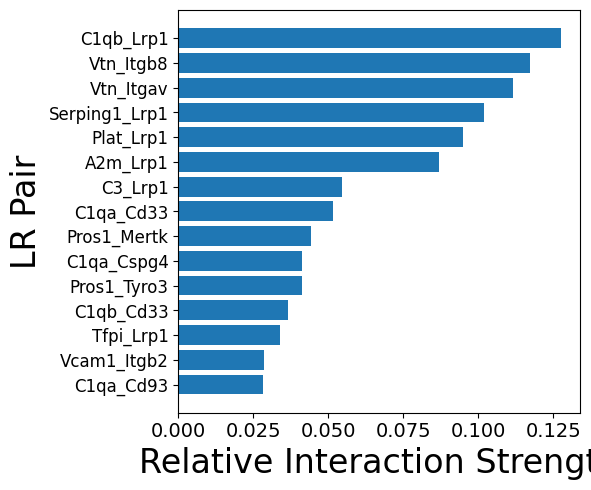

In [14]:
# First we run the pathway analysis to find the LR pairs involved in each pathway
results = mmcci.an.run_gsea(aged, organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_dotplot=False)

# We subset the LR pairs to only include those involved in the Complement and coagulation cascades pathway
aged = mmcci.an.pathway_subset(aged, gsea_results=results, terms=["Complement and coagulation cascades"], assay_name="complement", strict=False)
mmcci.plt.network_plot(aged.assays['complement']['overall'], node_colors=colors, title='Aged Complement and coagulation cascades')
mmcci.plt.lr_barplot(aged, assay="complement")

Number of interactions in Wnt: 71


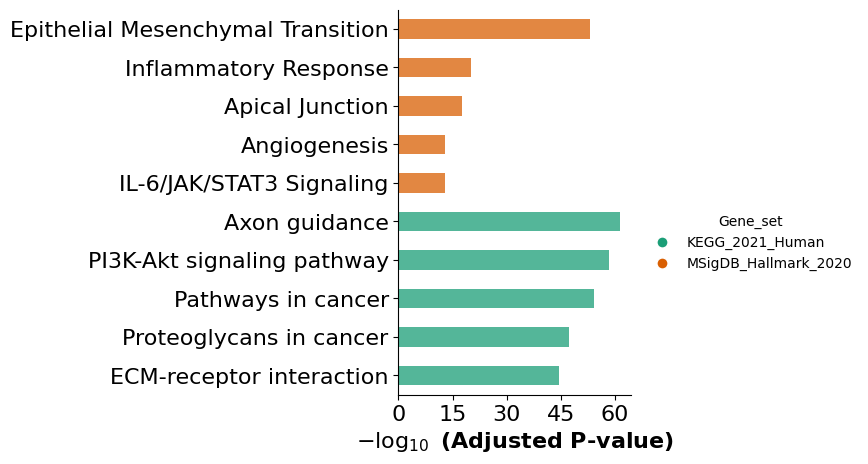

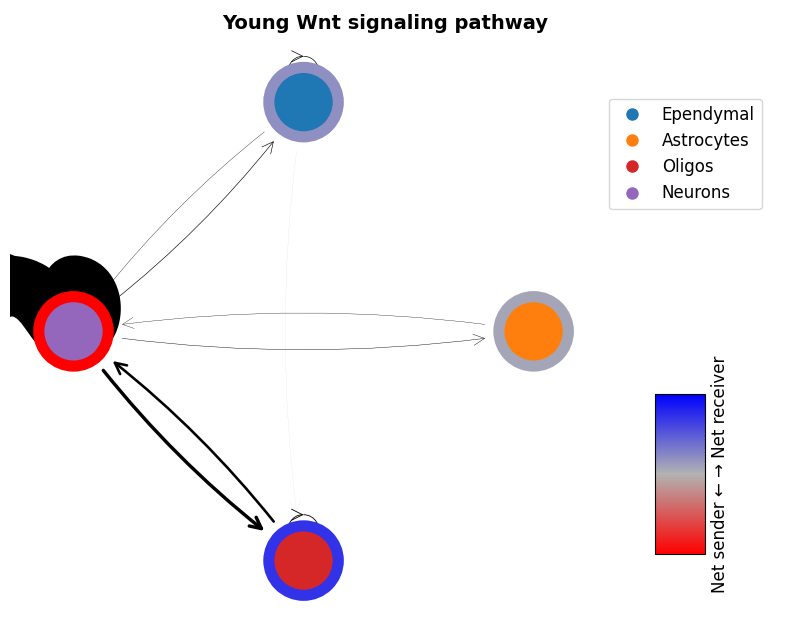

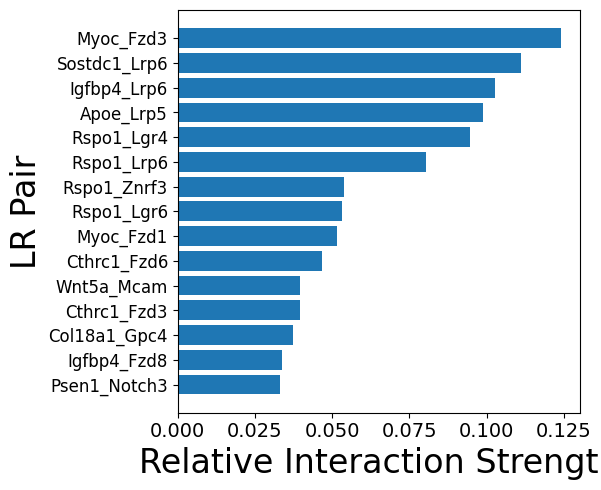

In [15]:
# First we run the pathway analysis to find the LR pairs involved in each pathway
results = mmcci.an.run_gsea(young, organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_dotplot=False)

# We subset the LR pairs to only include those involved in the Complement and coagulation cascades pathway
young = mmcci.an.pathway_subset(young, gsea_results=results, terms=["Wnt signaling pathway"], assay_name="Wnt", strict=False)
mmcci.plt.network_plot(young.assays['Wnt']['overall'], node_colors=colors, title='Young Wnt signaling pathway')
mmcci.plt.lr_barplot(young, assay="Wnt")